# Лабораторная работа 2. Вероятностные модели.

Результат лабораторной работы − отчет. Мы предпочитаем принимать отчеты в формате ноутбуков IPython (ipynb-файл). Постарайтесь сделать ваш отчет интересным рассказом, последовательно отвечающим на вопросы из заданий. Помимо ответов на вопросы, в отчете также должен быть код, однако чем меньше кода, тем лучше всем: нам − меньше проверять, вам — проще найти ошибку или дополнить эксперимент. При проверке оценивается четкость ответов на вопросы, аккуратность отчета и кода.

Мы уверены, что выполнение лабораторных работ занимает значительное время, поэтому не рекомендуем оставлять их на последний вечер перед сдачей.

### Оценивание и штрафы
* Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи)
* Максимально допустимая оценка за работу — 20 баллов. Также в результате выполнения заданий у вас получится решение [задачи конкурса](https://www.kaggle.com/c/competition-2-yandex-shad-spring-2021), которое после небольшой доработки принесёт ещё 5 баллов за пробитие Medium Baseline.
* Сдавать задание после указанного срока сдачи нельзя
* «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов и понижают карму (подробнее о плагиате см. на странице курса)
* Если вы нашли решение какого-то из заданий в открытом источнике, необходимо прислать ссылку на этот источник (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник)
* Не оцениваются задания с удалёнными формулировками
* Не оценивается лабораторная работа целиком, если она была выложена в открытый источник

Обратите внимание, что мы не ставим оценку за просто написанный код, корректная работоспособность которого не подтверждена экспериментами.


Цель этой лабораторной работы – научиться строить вероятностные модели и оптимизировать их параметры на примере задачи оценки риска заболевания сахарным диабетом. На задачу оценки риска болезни мы посмотрим со стороны страховой компании.

Если человек перестанет проходить обследования, и страховая так и не узнает, развился ли у него диабет, то и расходов, связанных с его заболеванием не будет, т.е. можно считать, что такой человек остался здоров. То же касается людей, у которых заболевание впервые обнаружат более чем через 5 лет.

Чтобы рассчитать математическое ожидание затрат на лечение клиента, страховая хочет получить в качестве результата работы модели непосредственно вероятность того, что у человека, не страдающего от заболевания, оно разовьётся в течение 5 лет. Поэтому в качестве метрики качества была выбрана бинарная кросс-энтропия (она же logloss) между предсказанными вероятностями и истинными метками классов:


$$\text{crossentropy}(y, p) = -\frac{1}{N}\sum_{i=1}^N\left[y_i\log(p_i) + (1-y_i)\log(1-p_i)\right]$$



**Задание 1** Препроцессинг (1 балл) 

- Прочитайте описание [набора данных и задачи конкурса 2](https://www.kaggle.com/c/competition-2-yandex-shad-spring-2021).
- Загрузите обучающий набор данных (X_train.csv, y_train.csv).
- Обратите внимание, что часть информации о клиентах неизвестна на момент заключения договора. Соответствующие признаки отсутствуют в X_test.csv.
- Заполните пропуски в данных. Для этого могут пригодиться методы из sklearn.impute или pandas.DataFrame.fillna.
- По желанию используйте любой препроцессинг данных, добавляйте новые признаки и т.п. ваша задача — добиться сходимости и высокого качества полученных моделей.
- Разбейте обучающую выборку на lab_train и lab_test, которые будете использовать для оценки всех построенных моделей в лабораторной работе. При желании использовать для оценки качества кросс-валидацию необходимо проконтролировать, чтобы для всех моделей использовались одни и те же разбиения.

In [737]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import log_loss

In [738]:
X_train = pd.read_csv("X_train.csv")
y_train = pd.read_csv("y_train.csv")
X_test = pd.read_csv("X_test.csv")

In [739]:
X_train.columns

Index(['Age', 'Gender', 'site', 'height', 'weight', 'Body Mass Index',
       'Systolic blood pressure', 'diastolic blood pressure',
       'Fasting plasma glucose', 'Cholesterol', 'Triglyceride',
       'High-density lipoprotein cholesterol ',
       'Low-density lipoprotein cholesterol', 'Alanine aminotransferase',
       'Aspartate transaminase', 'Blood urea nitrogen',
       'Creatinine clearance rate', 'Fasting plasma glucose (final visit)',
       'Diabetes diagnosed during followup', 'censor of diabetes at followup',
       'year of followup', 'smoking status', 'drinking status',
       'family history of diabetes'],
      dtype='object')

In [740]:
X_train.shape

(100000, 24)

In [741]:
def show_Nans(df):
    for column in df.columns:
        counter = df[column].isnull().sum()
        if counter != 0 :
            print(str(column) + " has " + str(counter) + " Nans");
show_Nans(X_train)
print()
show_Nans(X_test)

height has 2 Nans
Systolic blood pressure has 11 Nans
diastolic blood pressure has 12 Nans
Cholesterol has 2257 Nans
Triglyceride has 2277 Nans
High-density lipoprotein cholesterol  has 44444 Nans
Low-density lipoprotein cholesterol has 43884 Nans
Alanine aminotransferase has 837 Nans
Aspartate transaminase has 58247 Nans
Blood urea nitrogen has 10080 Nans
Creatinine clearance rate has 5200 Nans
Fasting plasma glucose (final visit) has 9 Nans
Diabetes diagnosed during followup has 99381 Nans
smoking status has 71412 Nans
drinking status has 71412 Nans

Systolic blood pressure has 12 Nans
diastolic blood pressure has 12 Nans
Cholesterol has 2597 Nans
Triglyceride has 2610 Nans
High-density lipoprotein cholesterol  has 50118 Nans
Low-density lipoprotein cholesterol has 49537 Nans
Alanine aminotransferase has 945 Nans
Aspartate transaminase has 65043 Nans
Blood urea nitrogen has 11471 Nans
Creatinine clearance rate has 5975 Nans
smoking status has 80191 Nans
drinking status has 80191 Nans

In [742]:
X_train["drinking status"].fillna(1, inplace = True)
X_train["smoking status"].fillna(1, inplace = True)
X_test["drinking status"].fillna(1, inplace = True)
X_test["smoking status"].fillna(1, inplace = True)
X_train["Diabetes diagnosed during followup"].fillna(0, inplace = True)
show_Nans(X_train)
print()
show_Nans(X_test)

height has 2 Nans
Systolic blood pressure has 11 Nans
diastolic blood pressure has 12 Nans
Cholesterol has 2257 Nans
Triglyceride has 2277 Nans
High-density lipoprotein cholesterol  has 44444 Nans
Low-density lipoprotein cholesterol has 43884 Nans
Alanine aminotransferase has 837 Nans
Aspartate transaminase has 58247 Nans
Blood urea nitrogen has 10080 Nans
Creatinine clearance rate has 5200 Nans
Fasting plasma glucose (final visit) has 9 Nans

Systolic blood pressure has 12 Nans
diastolic blood pressure has 12 Nans
Cholesterol has 2597 Nans
Triglyceride has 2610 Nans
High-density lipoprotein cholesterol  has 50118 Nans
Low-density lipoprotein cholesterol has 49537 Nans
Alanine aminotransferase has 945 Nans
Aspartate transaminase has 65043 Nans
Blood urea nitrogen has 11471 Nans
Creatinine clearance rate has 5975 Nans


In [743]:
from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
X_train_columns = X_train.columns
X_train_index = X_train.index
X_train = pd.DataFrame(imp_mean.fit_transform(X_train))
X_train.columns = X_train_columns
X_train.index = X_train_index

X_train.head()

,Age,Gender,site,height,weight,Body Mass Index,Systolic blood pressure,diastolic blood pressure,Fasting plasma glucose,Cholesterol,...,Aspartate transaminase,Blood urea nitrogen,Creatinine clearance rate,Fasting plasma glucose (final visit),Diabetes diagnosed during followup,censor of diabetes at followup,year of followup,smoking status,drinking status,family history of diabetes
0,53.0,1.0,13.0,163.5,64.1,24.00,106.0,68.0,4.83,3.84,...,24.030218,5.01,74.8,5.23,0.0,0.0,2.699521,3.0,3.0,0.0
1,26.0,2.0,3.0,156.0,68.5,28.10,98.0,68.0,5.12,4.12,...,15.300000,3.19,54.7,4.33,0.0,0.0,2.187543,3.0,3.0,0.0
2,40.0,2.0,5.0,152.0,47.0,20.30,111.0,63.0,5.62,4.30,...,17.000000,4.38,66.0,4.70,0.0,0.0,2.042437,3.0,3.0,0.0
3,34.0,1.0,4.0,177.0,68.0,21.71,133.0,81.0,4.84,4.35,...,26.500000,5.79,78.9,5.69,0.0,0.0,2.028747,1.0,1.0,0.0
4,34.0,1.0,3.0,178.0,68.0,21.50,124.0,84.0,3.73,5.02,...,24.030218,3.68,76.9,5.00,0.0,0.0,4.950034,3.0,3.0,0.0


In [744]:
show_Nans(X_train)
print()
show_Nans(X_test)


Systolic blood pressure has 12 Nans
diastolic blood pressure has 12 Nans
Cholesterol has 2597 Nans
Triglyceride has 2610 Nans
High-density lipoprotein cholesterol  has 50118 Nans
Low-density lipoprotein cholesterol has 49537 Nans
Alanine aminotransferase has 945 Nans
Aspartate transaminase has 65043 Nans
Blood urea nitrogen has 11471 Nans
Creatinine clearance rate has 5975 Nans


In [745]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
X_test_columns = X_test.columns
X_test_index = X_test.index
X_test = pd.DataFrame(imp_mean.fit_transform(X_test))
X_test.columns = X_test_columns
X_test.index = X_test_index

show_Nans(X_train)
show_Nans(X_test)
print('All clear')

All clear


In [746]:
from sklearn.model_selection import train_test_split
X_lab_train, X_lab_test, y_lab_train, y_lab_test = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
print(X_lab_train.shape)

(75000, 24)


**Задание 2** Бэйзлайн – константное предсказание (0.5 балла).

Как понять, работает ли та или иная модель, если сравить метрику не с чем? Чтобы было с чем сравнивать, соберём простой бэйзлайн: предскажем всем клиентам одну и ту же вероятность заболеть в течение 5 лет. Какое значение надо предсказать, чтобы минимизировать кросс-энтропию? Оцените качество такого предсказания.

In [747]:
y_lab_train.head()

,Id,diabettes in 5 years
98980,98980,0
69824,69824,0
9928,9928,0
75599,75599,0
95621,95621,0


In [748]:
constant_answer_probability = y_lab_train[y_lab_train['diabettes in 5 years'] == 1].shape[0] / y_lab_train.shape[0]
print(constant_answer_probability)
const_answer = np.array([constant_answer_probability] * y_lab_test.shape[0])

0.01872


In [750]:
from sklearn.metrics import accuracy_score

In [751]:
log_loss(y_lab_test['diabettes in 5 years'], const_answer)

0.09048095500903779

In [752]:
constant_answer_probability = y_train[y_train['diabettes in 5 years'] == 1].shape[0] / y_train.shape[0]
# constant_answer_for_whole_data_set = np.random.choice([0, 1], size = X_test.shape[0], 
#                                    p = [1 - constant_answer_probability, constant_answer_probability])
array = np.array(list([int(i), j] for i, j in enumerate([constant_answer_probability] * X_test.shape[0])))
print(array)
# creating a list of index names
index_values = list(range(X_test.shape[0]))
# creating a list of column names
column_values = ['Id', 'Prediction']
  
# creating the dataframe
df = pd.DataFrame(data = array, 
                  index = index_values, 
                  columns = column_values)
df["Id"] = pd.to_numeric(df["Id"], downcast='integer')
df.to_csv("kaggle2_constant_pred.csv", index=False)
df.head()

[[0.00000e+00 1.85600e-02]
 [1.00000e+00 1.85600e-02]
 [2.00000e+00 1.85600e-02]
 ...
 [1.11830e+05 1.85600e-02]
 [1.11831e+05 1.85600e-02]
 [1.11832e+05 1.85600e-02]]


,Id,Prediction
0,0,0.01856
1,1,0.01856
2,2,0.01856
3,3,0.01856
4,4,0.01856


взять среднее по результатам известным и получив вероятность заболевания для тех, кого мы знаем, выводить ответ для тех, кого мы не знаем

**Задание 3** Наивный байесовский классификатор (0.5 балла).

Предположим, что в каждом из классе признаки независимы и имеют нормальное распределение. Тогда подобрать параметры этого распределения поможет модель [Gaussian Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html). Обучите эту модель. Оцените её качество.





In [753]:
X_lab_train_additional = X_lab_train[['Fasting plasma glucose (final visit)', 'Diabetes diagnosed during followup', 'censor of diabetes at followup', 'year of followup']]
X_lab_test_additional = X_lab_test[['Fasting plasma glucose (final visit)', 'Diabetes diagnosed during followup', 'censor of diabetes at followup', 'year of followup']]

X_lab_train = X_lab_train.drop(columns = ['Fasting plasma glucose (final visit)', 'Diabetes diagnosed during followup', 'censor of diabetes at followup', 'year of followup'])
X_lab_test = X_lab_test.drop(columns = ['Fasting plasma glucose (final visit)', 'Diabetes diagnosed during followup', 'censor of diabetes at followup', 'year of followup'])

In [754]:
for column in X_train.columns:
    if column not in X_test.columns:
        print(column)
        print("is " + str(column) + " in X_lab_train or X_lab_test " + str((column in X_lab_train.columns or column in X_lab_test.columns)))
        print()

Fasting plasma glucose (final visit)
is Fasting plasma glucose (final visit) in X_lab_train or X_lab_test False

Diabetes diagnosed during followup
is Diabetes diagnosed during followup in X_lab_train or X_lab_test False

censor of diabetes at followup
is censor of diabetes at followup in X_lab_train or X_lab_test False

year of followup
is year of followup in X_lab_train or X_lab_test False



In [641]:
from sklearn.naive_bayes import GaussianNB

In [642]:
gaus_naive = GaussianNB()
gaus_naive.fit(X_lab_train, y_lab_train['diabettes in 5 years'])

GaussianNB()

In [643]:
gaus_naive_answer = gaus_naive.predict_proba(X_lab_test)

In [644]:
log_loss(y_lab_test['diabettes in 5 years'], gaus_naive_answer)

0.3966817735621222

NB - 0.3966817735621222

Constant - 0.09048095500903779

**Задание 4** Дискриминантный анализ (1.5 балла).

![](https://scikit-learn.org/stable/_images/sphx_glr_plot_lda_qda_001.png)

Теперь избавимся от предположения условной независимости признаков относительно целевой переменной. Таким образом, ковариационные матрицы распределений классов не обязательно будут даигональны. Мы можем наложить дополнительное условие в виде [равенства ковариационных матриц](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis) всех классов или [не делать этого](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis).

Попробуйте оба варианта. Какой сработал лучше и чем это можно объяснить?


In [645]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [755]:
y_lab_train = y_lab_train.drop(columns=['Id'])
y_lab_test = y_lab_test.drop(columns=['Id'])

In [647]:
linear_discriminant_analysis = LinearDiscriminantAnalysis()
linear_discriminant_analysis.fit(X_lab_train, np.array(y_lab_train[y_lab_train.columns[0]]))
linear_discriminant_analysis_answer = linear_discriminant_analysis.predict_proba(X_lab_test)

In [648]:
quadratic_discriminant_analysis = QuadraticDiscriminantAnalysis()
quadratic_discriminant_analysis.fit(X_lab_train, np.array(y_lab_train[y_lab_train.columns[0]]))
quadratic_discriminant_analysis_answer = quadratic_discriminant_analysis.predict_proba(X_lab_test)

In [649]:
print('LinearDiscriminantAnalysis')
log_loss(y_lab_test, linear_discriminant_analysis_answer)

LinearDiscriminantAnalysis


0.06391711773331388

In [650]:
print('QuadraticDiscriminantAnalysis')
log_loss(y_lab_test, quadratic_discriminant_analysis_answer)

QuadraticDiscriminantAnalysis


0.3418305777912362

Видно, что LDA показывает себя лучше, чем QDA (проводил ещё больше 10 тестов, но убрал их)

почему так?

The higher the dimension of the data set (the more predictors in a data set) the more parameters we have to estimate. This can lead to high variance and so we have to be careful when using QDA.

In conclusion, LDA is less flexible than QDA because we have to estimate fewer parameters. This can be good when we have only a few observations in our training data set so we lower the variance. On the other hand, when the K classes have very different covariance matrices then LDA suffers from high bias and QDA might be a better choice. So, what is comes down to is the bias-variance trade-off. Therefore, it is crucial to test the underlying assumptions of LDA and QDA on the data set and then use both methods to decide which one is more appropriate.

https://thatdatatho.com/linear-vs-quadratic-discriminant-analysis/

И, конечно же, на sklearn круто описано в чём состоят оба метода. Что QDA это тоже самое что и наивный байес, если допустить что каждая ковариационная матрица диагональна. И что LDA это ответвление QDA.

In the case of QDA, there are no assumptions on the covariance matrices of the Gaussians.

https://scikit-learn.org/stable/modules/lda_qda.html#lda-qda

Интересный факт про LDA:

LinearDiscriminantAnalysis can be used to perform supervised dimensionality reduction, by projecting the input data to a linear subspace consisting of the directions which maximize the separation between classes.

**Задание 5** Логистическая регрессия (1.5 балла).

Обучите модель логистической регрессии. Убедитесь, что модель сошлась. Удалось ли получить улучшение по сравнению с предыдущими моделями? Чем это можно объяснить?

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from copy import deepcopy
from sklearn.pipeline import Pipeline

log reg на 100 итерациях не сошлась для обычных данных, и после min max, но для 1000 итераций норм

После standard scaler сошлась даже на 100

In [31]:
logistic_regression = LogisticRegression(max_iter = 1000)
logistic_regression.fit(X_lab_train, np.array(y_lab_train[y_lab_train.columns[0]]))
logistic_regression_answer = logistic_regression.predict_proba(X_lab_test)
log_loss(y_lab_test, logistic_regression_answer)

0.06123387605615112

In [32]:
pipe_min_max = Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('logisticregression', LogisticRegression(max_iter = 1000))])

pipe_min_max.fit(X_lab_train, np.array(y_lab_train[y_lab_train.columns[0]]))  # apply scaling on training data

log_loss(y_lab_test, pipe_min_max.predict_proba(X_lab_test))

0.06140151939646529

In [33]:
pipe_stanard = Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

pipe_stanard.fit(X_lab_train, np.array(y_lab_train[y_lab_train.columns[0]]))  # apply scaling on training data

log_loss(y_lab_test, pipe_stanard.predict_proba(X_lab_test))

0.06127350219255029

LogReg удалось обогнать и константное предсказание, и даже LDA, которая была лучшей до этого момента.

Просто мега качественный и крутой ответ на вопрос, а почему так получилось? Честно, там так красиво и кратко, что не хочу копипастить и выделять что-то главное, т.к. там воды нет) Приложу фотку к ссылке, если не удобно открывать. Интерсное замечание про асимптотическую сложность в последнем пункте.

https://stats.stackexchange.com/questions/95247/logistic-regression-vs-lda-as-two-class-classifiers

For a two class classification problem, LDA predicts two normal density functions (one for each class) that creates a linear boundary where they intersect, whereas logistic regression only predicts the log-odd function between the two classes, which creates a boundary but does not assume density functions for each class.

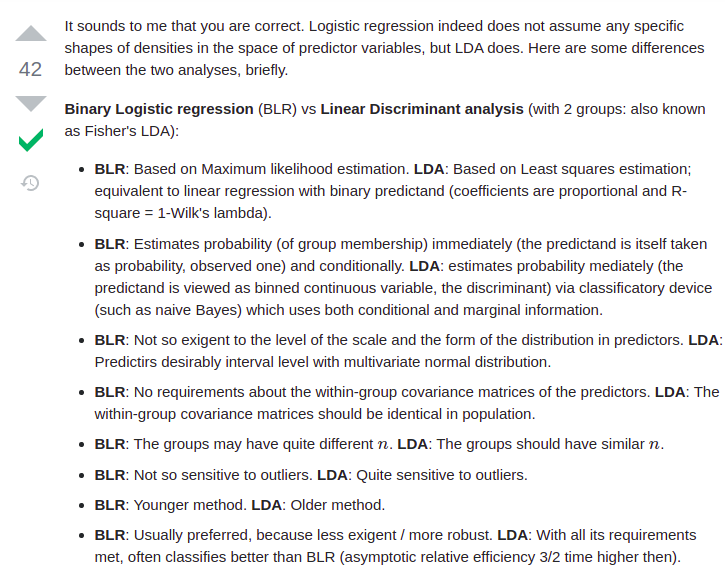

**Задание 6** GLM – обобщённые линейные модели (1.5 балла).

Как вы знаете, логистическая регрессия является частным случаем обобщённой линейной модели $\mu(\mathbb E(y|X)) = Xw$, где функция связи $\mu(u) = \log(\frac{u}{1-u})$, и $y|X\sim Bernoulli$.

Учитывая, что целевая переменная бинарная, изменять класс распределений $y|X$ не имеет смысла. А вот изменить функцию связи можно.

Обучите обобщённые линейные модели, в качестве функции связи использовав по крайней мере 2 разные функции, отличные от logit, использующейся в логистической регрессии.

Реализацию GLM можно взять в пакете [statsmodels](https://www.statsmodels.org/stable/glm).



In [34]:
import statsmodels.api as sm
from scipy import stats

Наш частный случай - log reg

In [35]:
binomial_logit = sm.GLM(y_lab_train, X_lab_train, family=sm.families.Binomial(sm.families.links.logit()))
binomial_logit_answer = binomial_logit.fit().predict(X_lab_test)
# print(gauss_log_results.summary())
log_loss(y_lab_test, binomial_logit_answer)

0.06123648594134909

cloglog вариант

In [36]:
binomial_cloglog = sm.GLM(y_lab_train, X_lab_train, family=sm.families.Binomial(sm.families.links.cloglog()))
binomial_cloglog_answer = binomial_cloglog.fit().predict(X_lab_test)
# print(gauss_log_results.summary())
log_loss(y_lab_test, binomial_cloglog_answer)

0.061743850798700144

probit вариант - показал хороший результат

In [37]:
binomial_probit = sm.GLM(y_lab_train, X_lab_train, family=sm.families.Binomial(sm.families.links.probit()))
binomial_probit_answer = binomial_probit.fit().predict(X_lab_test)
# print(gauss_log_results.summary())
log_loss(y_lab_test, binomial_probit_answer)

0.0616893848147768

В этой части работы мы построим теперь вероятностную модель, учитывающую специфику задачи.

**Задание 7** Оценка Нельсона – Аалена (1.5 балла).

Поскольку изначально все участники исследования были здоровы, заболеть, скажем, через месяц у них очень мало шансов. Скорее всего, это значило бы ошибку при проведении анализов. А вот заболеть через несколько лет шансов уже больше.

Зависимость риска заболеть в данный момент времени $t$ при условии, что до момента $t$ человек оставался здоров, называется функцией риска ([hazard function](https://en.wikipedia.org/wiki/Survival_analysis#Hazard_function_and_cumulative_hazard_function)). В других задачах она позволяет определить, люди какого возраста наиболее подвержены заболеванию, или в какой момент эпидемии риск заразиться максимален.

Оцените, какова вероятность заболеть через $t$ лет после начала исследования, воспользовавшись оценками Нельсона – Аалена:

$$\hat H_{NA}(t) = \frac{d_t}{n_t},$$

Где $n_t$ – количество участников, остававшихся здоровыми и не прекративших участие в исследовании до года $t$, $d_t$ – количество участников, заболевших в год $t.$


Изобразите $\hat H_{NA}(t)$ на графике.

In [38]:
from sklearn.neighbors import KernelDensity
import math
from scipy.interpolate import interp1d

In [39]:
X_lab_train_additional = X_lab_train_additional.sort_values('year of followup')
X_lab_train_additional.head(-5)

,Fasting plasma glucose (final visit),Diabetes diagnosed during followup,censor of diabetes at followup,year of followup
88720,4.50,0.0,0.0,2.001369
35435,5.10,0.0,0.0,2.001369
90241,7.24,0.0,1.0,2.001369
86055,4.73,0.0,0.0,2.001369
43173,5.91,0.0,0.0,2.001369
...,...,...,...,...
97692,4.58,0.0,0.0,5.842574
36874,4.99,0.0,0.0,5.842574
12819,4.49,0.0,0.0,5.842574
14523,4.58,0.0,0.0,5.842574


/home/elephant/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/home/elephant/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/home/elephant/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/home/elephant/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/elephant/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/home/elephant/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key w

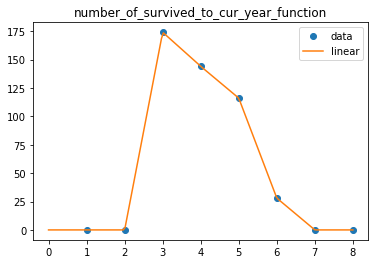

In [109]:
year_to_diagnosed = list()# [[year, 0] for year in X_lab_train_additional['year of followup'].unique()]
# for i, year in enumerate(X_lab_train_additional['year of followup'].unique()):
#     year_to_diagnosed.append([year, sum(X_lab_train_additional[X_lab_train_additional['year of followup'] == year]['Diabetes diagnosed during followup'] == 1)])

for i in np.arange(int(max(X_lab_train_additional['year of followup']) + 1)):
    year_to_diagnosed.append([i + 1, (X_lab_train_additional
                                     [X_lab_train_additional['year of followup'] >= i]
                                     [X_lab_train_additional['year of followup'] < i + 1]
                                     [X_lab_train_additional['Diabetes diagnosed during followup'] == 1]).shape[0]])
    
    
year_to_diagnosed = np.array(year_to_diagnosed)
year_to_diagnosed = np.vstack(([-math.inf, 0], year_to_diagnosed))
year_to_diagnosed = np.vstack((year_to_diagnosed, [math.inf, 0]))
year_to_diagnosed_func = interp1d(year_to_diagnosed[:, 0], year_to_diagnosed[:, 1], kind='linear')

plt.close()
x = year_to_diagnosed[:, 0]
y = year_to_diagnosed[:, 1]
xnew = np.linspace(0, 8, num=160, endpoint=True)
plt.plot(x, y, 'o', xnew, year_to_diagnosed_func(xnew), '-')
plt.title("number_of_survived_to_cur_year_function")
plt.legend(['data', 'linear'], loc='best')
plt.show()

In [110]:
number_of_survived_to_cur_year = list()
"""
for i, year in enumerate(X_lab_train_additional['year of followup'].unique()):
    number_of_survived_to_cur_year.append([year, 
                                           np.vstack((
        X_lab_train_additional[X_lab_train_additional['year of followup'] < year][
            X_lab_train_additional['Diabetes diagnosed during followup'] == 0],
        X_lab_train_additional[X_lab_train_additional['year of followup'] >= year]                                 
                                           )).shape[0]])
"""                                
                                                           
for i in np.arange(int(max(X_lab_train_additional['year of followup']) + 1)):
    number_of_survived_to_cur_year.append([i + 1, \
        (X_lab_train_additional.shape[0] - \
        X_lab_train_additional[X_lab_train_additional['year of followup'] < i].shape[0])])
        
        
number_of_survived_to_cur_year = np.array(number_of_survived_to_cur_year)
print(number_of_survived_to_cur_year)

[[    1 75000]
 [    2 75000]
 [    3 75000]
 [    4 36823]
 [    5 16008]
 [    6  3061]
 [    7     2]
 [    8     1]]


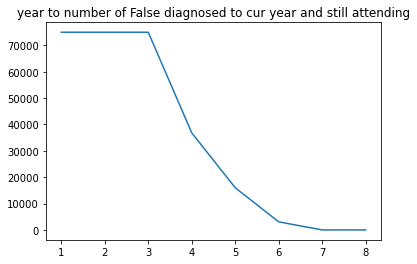

In [111]:
plt.title("year to number of False diagnosed to cur year and still attending")
plt.plot(number_of_survived_to_cur_year[:, 0], number_of_survived_to_cur_year[:, 1])

In [112]:
print(max(number_of_survived_to_cur_year[:, 1]), min(number_of_survived_to_cur_year[:, 1]))

75000 1


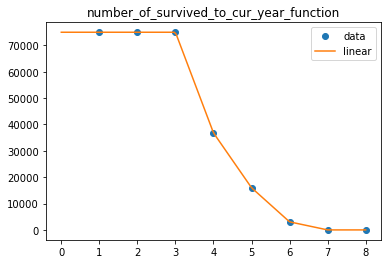

In [113]:
number_of_survived_to_cur_year = np.vstack(([-math.inf, 75000], number_of_survived_to_cur_year))
number_of_survived_to_cur_year = np.vstack((number_of_survived_to_cur_year, [math.inf, 0]))
number_of_survived_to_cur_year_function = interp1d(number_of_survived_to_cur_year[:, 0], number_of_survived_to_cur_year[:, 1], kind='linear')

plt.close()
x = number_of_survived_to_cur_year[:, 0]
y = number_of_survived_to_cur_year[:, 1]
xnew = np.linspace(0, 8, num=160, endpoint=True)
plt.plot(x, y, 'o', xnew, number_of_survived_to_cur_year_function(xnew), '-')
plt.title("number_of_survived_to_cur_year_function")
plt.legend(['data', 'linear'], loc='best')
plt.show()

In [120]:
def hazard_function(t):
    # чтобы на ноль не делить добавил вниз 1, с нашими количествами не должно решать особо
    return year_to_diagnosed_func(t) / (number_of_survived_to_cur_year_function(t) + 1)

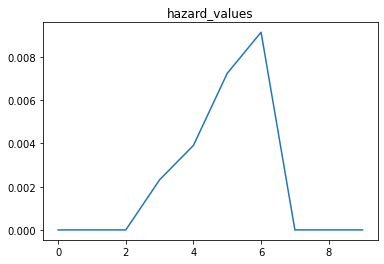

In [121]:
hazard_values = list()
for i in np.arange(10):
    hazard_values.append([i, hazard_function(i)])
hazard_values = np.array(hazard_values)    
plt.title("hazard_values")
plt.plot(hazard_values[:, 0], hazard_values[:, 1])

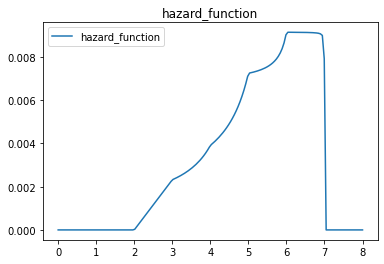

In [122]:
xnew = np.linspace(0, 8, num=160, endpoint=True)
plt.plot(xnew, hazard_function(xnew), '-')
plt.title("hazard_function")
plt.legend(['hazard_function'], loc='best')
plt.show()

###### hazard_function - наша функция, которая показывает оценку нельсона аллена для любого t

Оценка Нельсона – Аалена не персонализирована, т.е. для неё мы никак не использовали признаки пациентов.

Модель пропорциональных рисков Кокса (Cox Proportional Hazard Model, CPHM) моделирует отношение риска для пациента к среднему риску по всем пациентам для данного момента времени. Поскольку это отношение рисков – положительное число, его обычно моделируют как $e^{Xw}$, где $X$ – признаки пациентов, $w$ – обучаемый вектор весов. Таким образом,

$$\hat H_{Cox}(x, t) = \hat H_{NA}(t)e^{xw}.$$

Обратите внимание, что в линейной части CPHM не используют свободный член: в некотором смысле его роль играет $\hat H_{NA}(t)$.

Вероятность заболеть ровно в момент $t$ – это произведение вероятности не заболеть до момента $t$ на вероятность заболеть в момент $t$ при условии здоровья до момента $t$. Таким образом, функция правдоподобия имеет вид

$$L = \prod_{i=1}^N \left[(\hat H_{NA}(T_i)e^{x_iw})^{y_i}(1 - \hat H_{NA}(T_i)e^{x_iw})^{1-y_i}\prod_{t=0}^{T_i-1}\left(1-\hat H_{NA}(t)e^{x_iw}\right)\right],$$

где $T_i$ – момент последней записи, $i$-го пациента.
Максимизация правдоподобия эквивалентна минимизации «минус» нормированного логарифма правдоподобия.

$$\mathcal L = -\frac{1}{N}\log L = -\frac{1}{N}\sum_{i=1}^N\left[y_i\left(\log \hat H_{NA}(T_i) + x_iw\right) + (1-y_i)\left(\log (1-\hat H_{NA}(T_i) e^{x_iw})\right) + \sum_{t=0}^{T_i - 1}\log(1-\hat H_{NA}(t)e^{x_iw})\right]$$

$$\nabla_w\mathcal L = \frac{1}{N}\sum_{i=1}^N\left[-x_iy_i + (1-y_i)\frac{\hat H_{NA}(T_i)e^{x_iw}x_i}{1-\hat H_{NA}(T_i)e^{x_iw}} + \sum_{t=0}^{T_i-1}\frac{\hat H_{NA}(t)e^{x_iw}x_i}{1-\hat H_{NA}(t)e^{x_iw}}\right]$$

Минимизировать $\mathcal L$ можно градиентным спуском, итеративно применяя формулу

$$w:= w - \eta \nabla_w\mathcal L - \eta Cw$$

где $\eta > 0$ — размер шага (learning rate), $C\geq 0$ — коэффициент регуляризации.




**Задание 8** Cox Proportional Hazard Model (CPHM) (3.5 балла).

 Реализуйте градиентный спуск и примените его к модели CPHM.

В качестве критерия останова мы предлагаем использовать следующие условия:
 - евклидова норма разности текущего и нового векторов весов стала меньше, чем 1e-4
 - ограничение на число итераций (например, 10000)
 
Для начальной инициализации весов нужно сравнить следующие подходы:
 - нулевая начальная инициализация
 - случайная
 
Выполните следующие пункты и прокомментируйте полученные результаты:
- Рассмотрите как влияет размер шага на сходимость (попробуйте не менее 5-ти различных значений).
- Рассмотрите регуляризованную модель (не менее 5-ти различных коэффициентов регуляризации), которая описана выше, а также модель без регуляризатора. Сравните, влияет ли наличие регуляризации на скорость сходимости и качество (под качеством во всех случаях подразумевается значение исходного, нерегуляризованного функционала).
- Исследуйте качество оптимизируемого функционала в зависимости от номера итерации (при правильной реализации и подходящем размере шага он должен убывать).
- Влияет ли выбор начальной инициализации весов на скорость и качество?

В каждом пункте требуется построить необходимые графики скорости/качества и дать исчерпывающие выводы.

##### Cox Proportional Hazard Model

In [124]:
from sklearn.base import BaseEstimator
from sklearn.preprocessing import normalize
from numpy.linalg import norm

In [165]:
class CPHazard(BaseEstimator):
    # weight_init - 'random', 'zeroes', default = 'random' unifrom(0, precision * 100)
    # learning_rate - float, default = 0.01
    # C, коэффициент регуляризации, float, default = 0.0
    # max_iter - int, default = 100
    # precision - float, default = 1e-4
    # hazard_func - func, default = hazard_function defined higher
    
    def __init__(self, hazard_func = hazard_function, weights_init='random', learning_rate = 0.01, C = 0.0,
                 max_iters = 100, precision = 0.0001):
        self.weights_init = weights_init
        self.learning_rate = learning_rate
        self.C = C
        self.max_iters = max_iters
        self.iters = 0
        self.precision = precision
        self.cur_precision = math.inf
        self.weights = np.array(0)
        self.previous_weights = np.array(0)
        self.hazard_func = hazard_func
        self.X = None
        self.y = None
        self.X_last_follow_ups = None
        self.gradient = self.gradient_for_CPHazard
        self.mine_optimized_value_func = self.mine_optimized_value
        self.optimized_values = list()
        
    def fit(self, X, y, last_follow_ups):
        self.X = np.array(X)
        self.y = np.array(y)
        self.X_last_follow_ups = np.array(last_follow_ups)
        
        if (self.weights_init == 'zeroes'):
            self.weights = [0] * X.shape[1]
            
        if (self.weights_init == 'random'):
            self.weights = np.random.uniform(0, self.precision * 100, X.shape[1])
            
        if (self.weights_init == 'random_second_test'):
            self.weights = 10 * np.random.uniform(0, self.precision * 100, X.shape[1])
            
        if (self.weights_init == 'random_third_test'):
            self.weights = 100 * np.random.uniform(0, self.precision * 100, X.shape[1])
            
        if (self.weights_init == 'random_forth_test'):
            self.weights = 300 * np.random.uniform(0, self.precision * 100, X.shape[1])
            
        if (self.weights_init == 'standart'):
            self.weights = np.random.uniform(-1, 1, X.shape[1])
            self.weights /= self.X.shape[0]
            
        self.weights = np.array(self.weights)    
        
        while self.cur_precision > self.precision and self.iters < self.max_iters:
            self.previous_weights = self.weights 
            #print(self.weights)
            self.weights = self.weights - self.learning_rate * self.gradient() - \
                self.learning_rate * self.C * self.weights
            
            self.cur_precision = norm(self.weights - self.previous_weights) 
            #print(self.gradient())
            #print(self.cur_precision)
            self.iters += 1 
            #print("Iteration ", self.iters ,"\nweights are ", self.weights)    
            #print("Iteration ", self.iters)    
            self.optimized_values.append(self.mine_optimized_value_func())
            #print("new value = " + str(self.mine_optimized_value_func()))
            #print(self.optimized_values)
        return self
        
    def predict_proba(self, X_test, t = 5):
        # t - years, to which we predict, default = 5
        print("maybe WRONG IMPL!!!!!! WARNING, actually returnd hazard_COX(t) for each x_i")
        return self.hazard_func(t) * np.exp(np.dot(X_test, self.weights))
        
    def predict(self, X_test, t = 5):
        print("wasn't checked")
        return np.random.choice(1, p = predict_proba(X_test, t))
    
    def number_of_iterations(self):
        return self.iters
    
    def get_optimized_values(self):
        return np.array(self.optimized_values)
    
    def gradient_for_CPHazard(self):
        N = self.X.shape[0]
        #-------------------------------------
        N = self.X.shape[1]
        #N = 100
        #-------------------------------------
        gradient = 0
        for i in np.arange(N):
            helper = np.exp(self.X[i] @ self.previous_weights)
            
            gradient -= self.X[i] * self.y[i]
        
            second_part = self.hazard_func(self.X_last_follow_ups[i]) * helper
            
            gradient += (1 - self.y[i]) * second_part * self.X[i] / (1 - second_part)

            third_part = 0
            for j in np.arange(int(self.X_last_follow_ups[i])):
                third_part_helper = self.hazard_func(j) * helper
                third_part += third_part_helper * self.X[i] / (1 - third_part_helper)
            
            gradient += third_part
        return gradient / N
    
    def mine_optimized_value(self):
        N = self.X.shape[0]
        #-------------------------------------
        N = self.X.shape[1]
        #N = 100
        #-------------------------------------
        
        value = 0
        for i in np.arange(N):
            # PREV or CUR WEIGHTS, Can change output for first iterations
            helper = self.X[i] @ self.previous_weights
            helper_exp = np.exp(helper)
            
            first_part = self.y[i] * (np.log(self.hazard_func(self.X_last_follow_ups[i])) + helper)
            #print("optimized first_part = " + str(first_part))
            
            second_part = (1 - self.y[i]) * (np.log(1 - self.hazard_func(self.X_last_follow_ups[i]) * helper_exp))
            #print("optimized second_part = " + str(second_part))
            third_part = 0
            for j in np.arange(int(self.X_last_follow_ups[i])):
                third_part += np.log(1 - self.hazard_func(j) * helper_exp)
            #print("optimized third_part = " + str(third_part))
            #print("part of thrid_part = " + str(self.hazard_func(j) * np.exp(self.X[i] @ self.previous_weights)))
            value += first_part + second_part + third_part
        
        value = -1 * value / N
        return value

In [166]:
scaler = MinMaxScaler()
X_lab_train_minmax = scaler.fit_transform(X_lab_train)
X_lab_test_minmax = scaler.fit_transform(X_lab_test)

In [167]:
CPHM = CPHazard(hazard_func = hazard_function, weights_init='random', learning_rate = 0.01, C = 0.0,
                 max_iters = 100, precision = 0.00001)
CPHM.fit(X_lab_train, y_lab_train, X_lab_train_additional['year of followup'])
print(CPHM.number_of_iterations())

45


##### 1. Рассмотрите как влияет размер шага на сходимость (попробуйте не менее 5-ти различных значений).

In [177]:
number_of_iterations = list()
lr_values = np.array([0.1, 0.05, 0.01, 0.005, 0.001, 0.0001])
for l_r in lr_values:
    CPHM = CPHazard(hazard_func = hazard_function, weights_init='random', learning_rate = l_r, C = 0.0,
                    max_iters = 1000, precision = 0.00001)
    CPHM.fit(X_lab_train, y_lab_train, X_lab_train_additional['year of followup'])
    number_of_iterations.append(CPHM.number_of_iterations())
    print(str(l_r) + " learning rate, iterations: " + str(CPHM.number_of_iterations()))
          
number_of_iterations = np.array(number_of_iterations)

0.1 learning rate, iterations: 364
0.05 learning rate, iterations: 327
0.01 learning rate, iterations: 53
0.005 learning rate, iterations: 1
0.001 learning rate, iterations: 1
0.0001 learning rate, iterations: 1


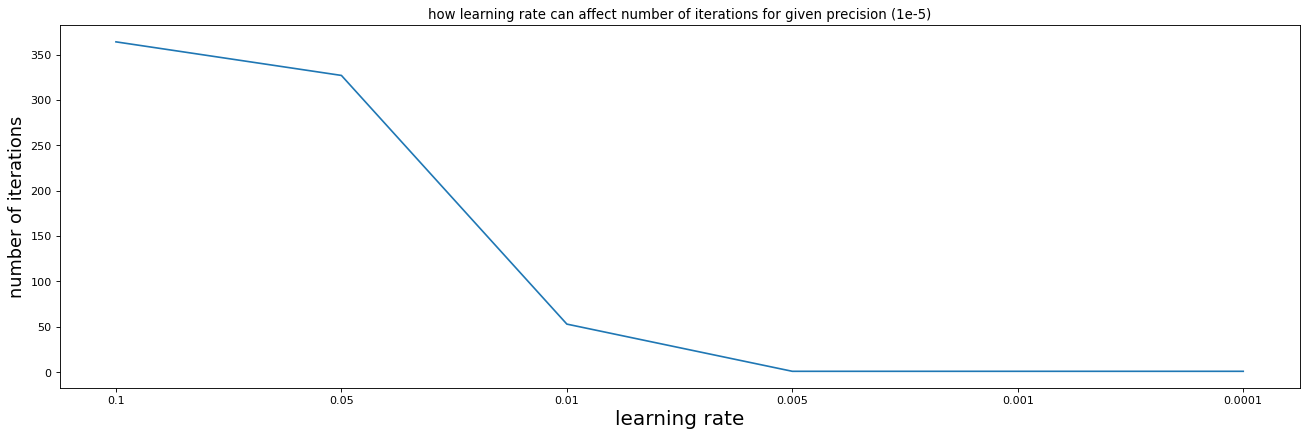

In [186]:
from matplotlib.pyplot import figure
    
fig = figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
    
plt.xticks(list(range(lr_values.shape[0])), lr_values)
plt.plot(number_of_iterations)

plt.xlabel('learning rate', fontsize=18)
plt.ylabel('number of iterations', fontsize=16)
plt.title("how learning rate can affect number of iterations for given precision (1e-5)")
plt.show()

При дефолте модель генерит веса по нормальному распределнию между 0 и 0.1. При больших шагах мы можем вообще не сойтись никогда, и будет твориться в модели просто какой-то хаос :) Для подобранного learning_step всё идёт стандартно, инициализировали веса, спокойно двигаемся в нужное направление и всё хорошо. При меньших learning_rate тоже понятно, градиент модели может даже не успеть на одном шаге достаточно поменять веса, чтобы не подпасть под ограничение precision, и модель подумает что мы уже в минимуме, либо же из-за различных данных будет сходиться невероятно долго и ограничение по шагам не позволит сойтись. Нужно опдбирать этот гиперпараметр.

##### 2. Рассмотрите регуляризованную модель (не менее 5-ти различных коэффициентов регуляризации), которая описана выше, а также модель без регуляризатора. Сравните, влияет ли наличие регуляризации на скорость сходимости и качество (под качеством во всех случаях подразумевается значение исходного, нерегуляризованного функционала).

In [221]:
number_of_iterations_for_C = list()
optimized_values_for_C = list()
c_values = np.array([70, 40, 30, 20, 15, 10, 1, 0.1, 0.05, 0.01, 0.005, 0])
for c in c_values:
    CPHM = CPHazard(hazard_func = hazard_function, weights_init='random', learning_rate = 0.01, C = c,
                 max_iters = 1000, precision = 0.00001)
    CPHM.fit(X_lab_train, y_lab_train, X_lab_train_additional['year of followup'])
    number_of_iterations_for_C.append(CPHM.number_of_iterations())
    optimized_values_for_C.append(CPHM.get_optimized_values())
    print(str(c) + " C,  iterations: " + str(CPHM.number_of_iterations()))
          
number_of_iterations_for_C = np.array(number_of_iterations_for_C)
optimized_values_for_C = np.array(optimized_values_for_C)

70.0 C,  iterations: 6
40.0 C,  iterations: 11
30.0 C,  iterations: 14
20.0 C,  iterations: 19
15.0 C,  iterations: 24
10.0 C,  iterations: 31
1.0 C,  iterations: 105
0.1 C,  iterations: 38
0.05 C,  iterations: 34
0.01 C,  iterations: 17
0.005 C,  iterations: 25
0.0 C,  iterations: 58


/home/elephant/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  del sys.path[0]


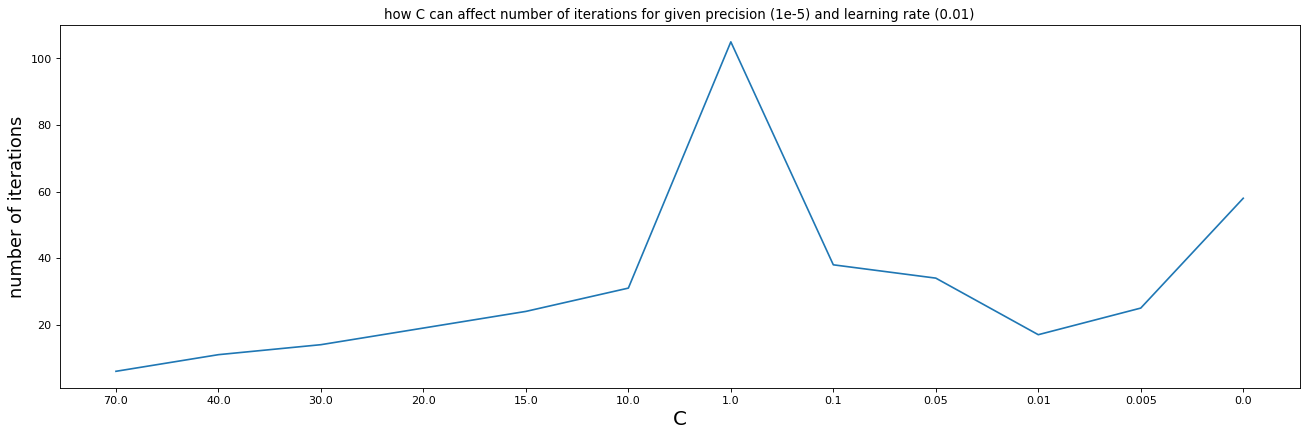

In [222]:
fig = figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
    
plt.xticks(list(range(c_values.shape[0])), c_values)
plt.plot(number_of_iterations_for_C)

plt.xlabel('C', fontsize=18)
plt.ylabel('number of iterations', fontsize=16)
plt.title("how C can affect number of iterations for given precision (1e-5) and learning rate (0.01)")
plt.show()

Для С = 0 нет регуляризации, и модель впринципе имеет хорошую скорость сходимости. Остальное видно на графике.

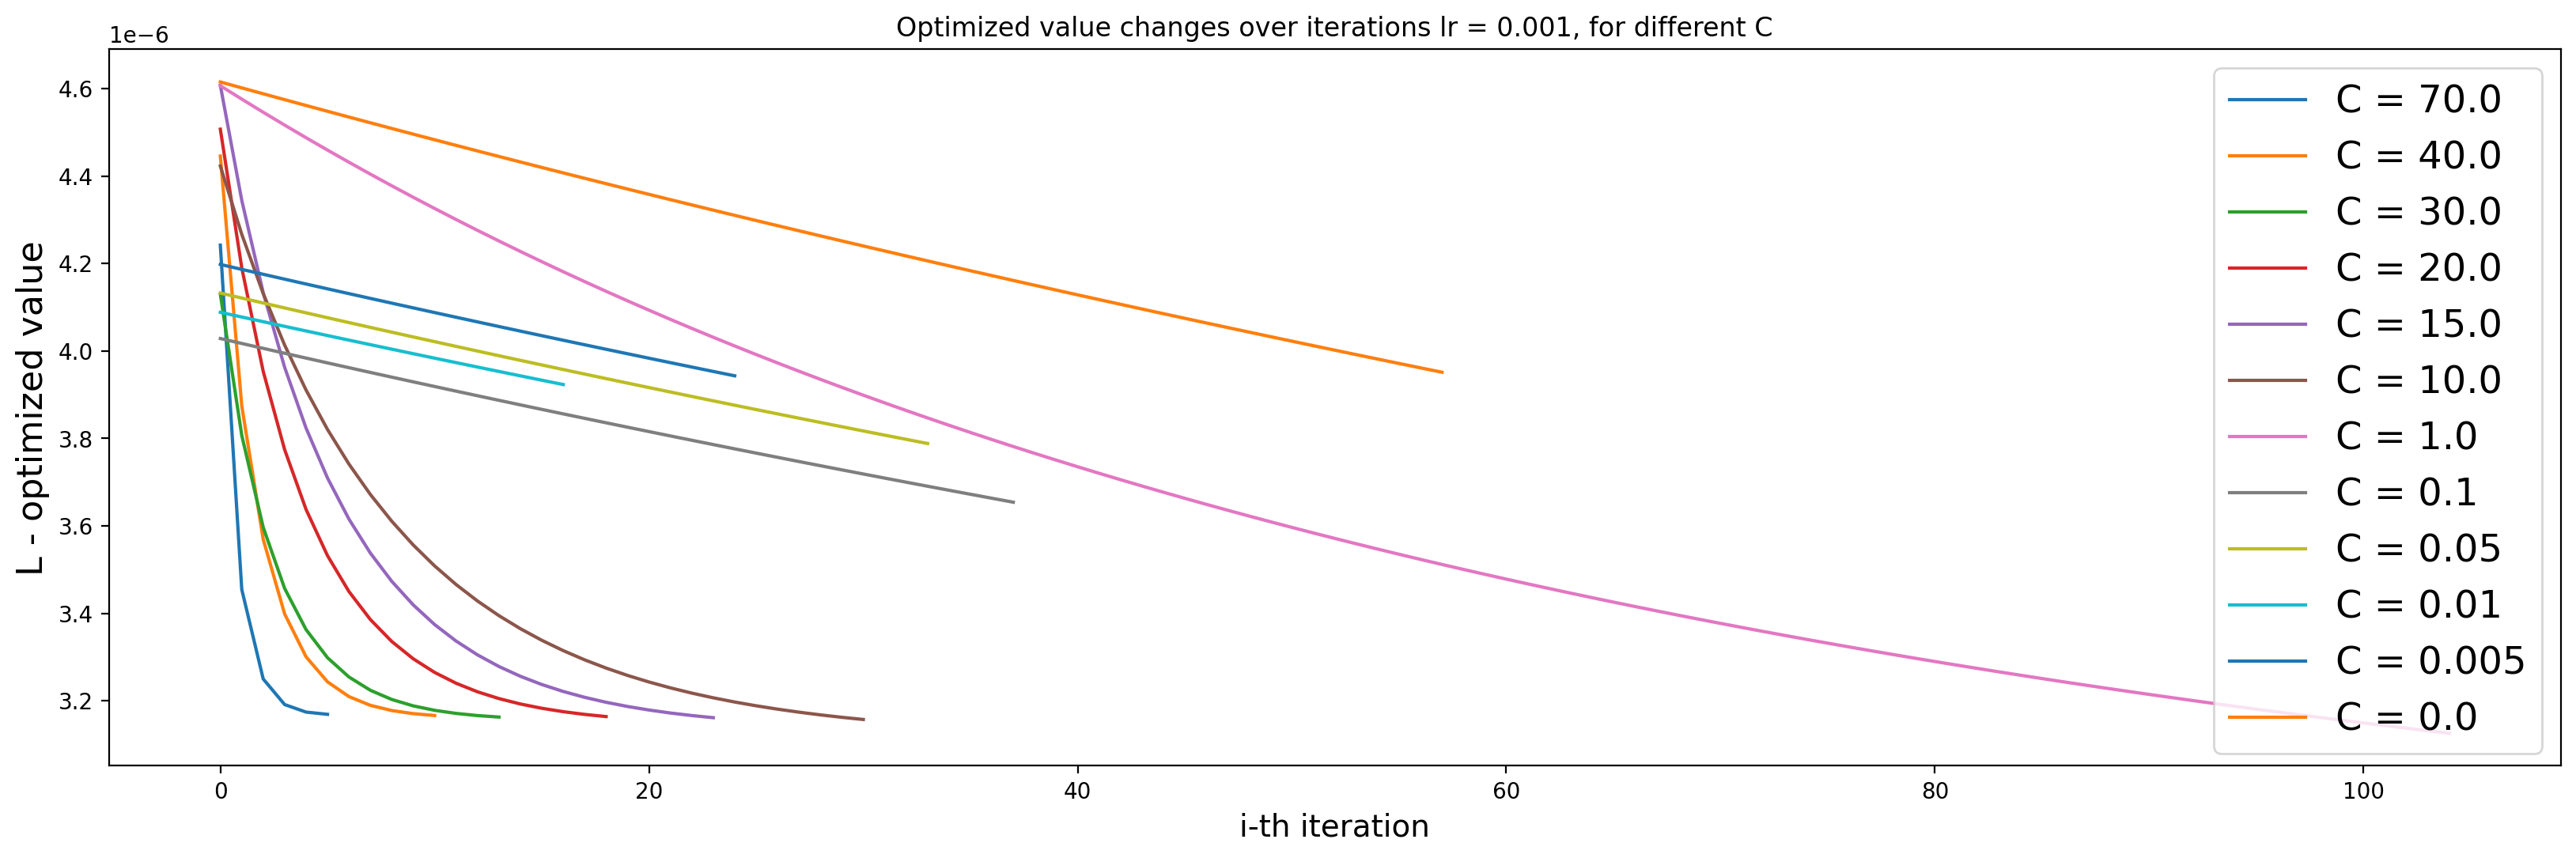

In [240]:
fig = figure(num=None, figsize=(20, 6), dpi=200, facecolor='w', edgecolor='k')

for i, c in enumerate(c_values):
    plt.plot(optimized_values_for_C[i], label="C = " + str(c))

plt.xlabel('i-th iteration', fontsize=14)
plt.ylabel('L - optimized value', fontsize=16)
plt.legend(loc='best', fontsize='xx-large')
plt.title("Optimized value changes over iterations lr = 0.001, for different C")
plt.show()

Для некоторых значений мы даже не достигли оптимума! Только для значений С >= 1 мы дошли до оптимума, и видно, что чем больше С, тем быстрее мы сходились, для нашего набора конечно, поэтому я думаю оставить С = 10. С чем это связано?

Подбирая коэффицент регуляризации мы однозначно ускоряем скорость сходимости модели, но т.к. мы изменяем и саму функцию изменения весов на шаге мы можем получать и немного разные ответы, но опять же, подобрав нужное C мы улучшаем и ответ. Это случается из-за того, какие именно у нас данные, плоские как пол долгое время с резким падением, или плавно спускающиеся, или когда нам нужно делать шажки поменьше, всё зависит от данных и регуляризация помогает нам это обработать.

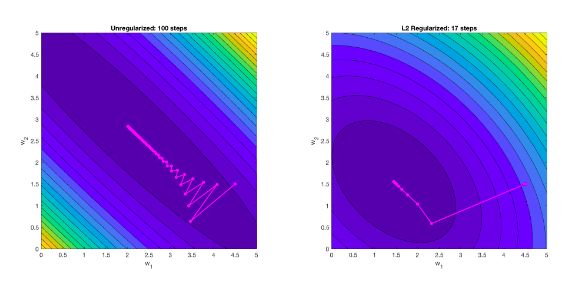

https://stats.stackexchange.com/questions/393309/convex-optimization-is-gradient-descent-faster-if-a-regularizer-is-added#:~:text=Yes%2C%20there%20are%20situations%20where,and%20the%20solution%20will%20differ.

P.S. нормализация данных даёт невероятный прирост скорости тоже и сколько-то защищает от взрыва градиентов же даже.

##### 3. Исследуйте качество оптимизируемого функционала в зависимости от номера итерации (при правильной реализации и подходящем размере шага он должен убывать).

In [217]:
CPHM = CPHazard(hazard_func = hazard_function, weights_init='random', learning_rate = 0.01, C = 10.0,
                 max_iters = 1000, precision = 0.00001)
CPHM.fit(X_lab_train, y_lab_train, X_lab_train_additional['year of followup'])
print(CPHM.number_of_iterations())

32


In [218]:
optimized_values = CPHM.get_optimized_values()

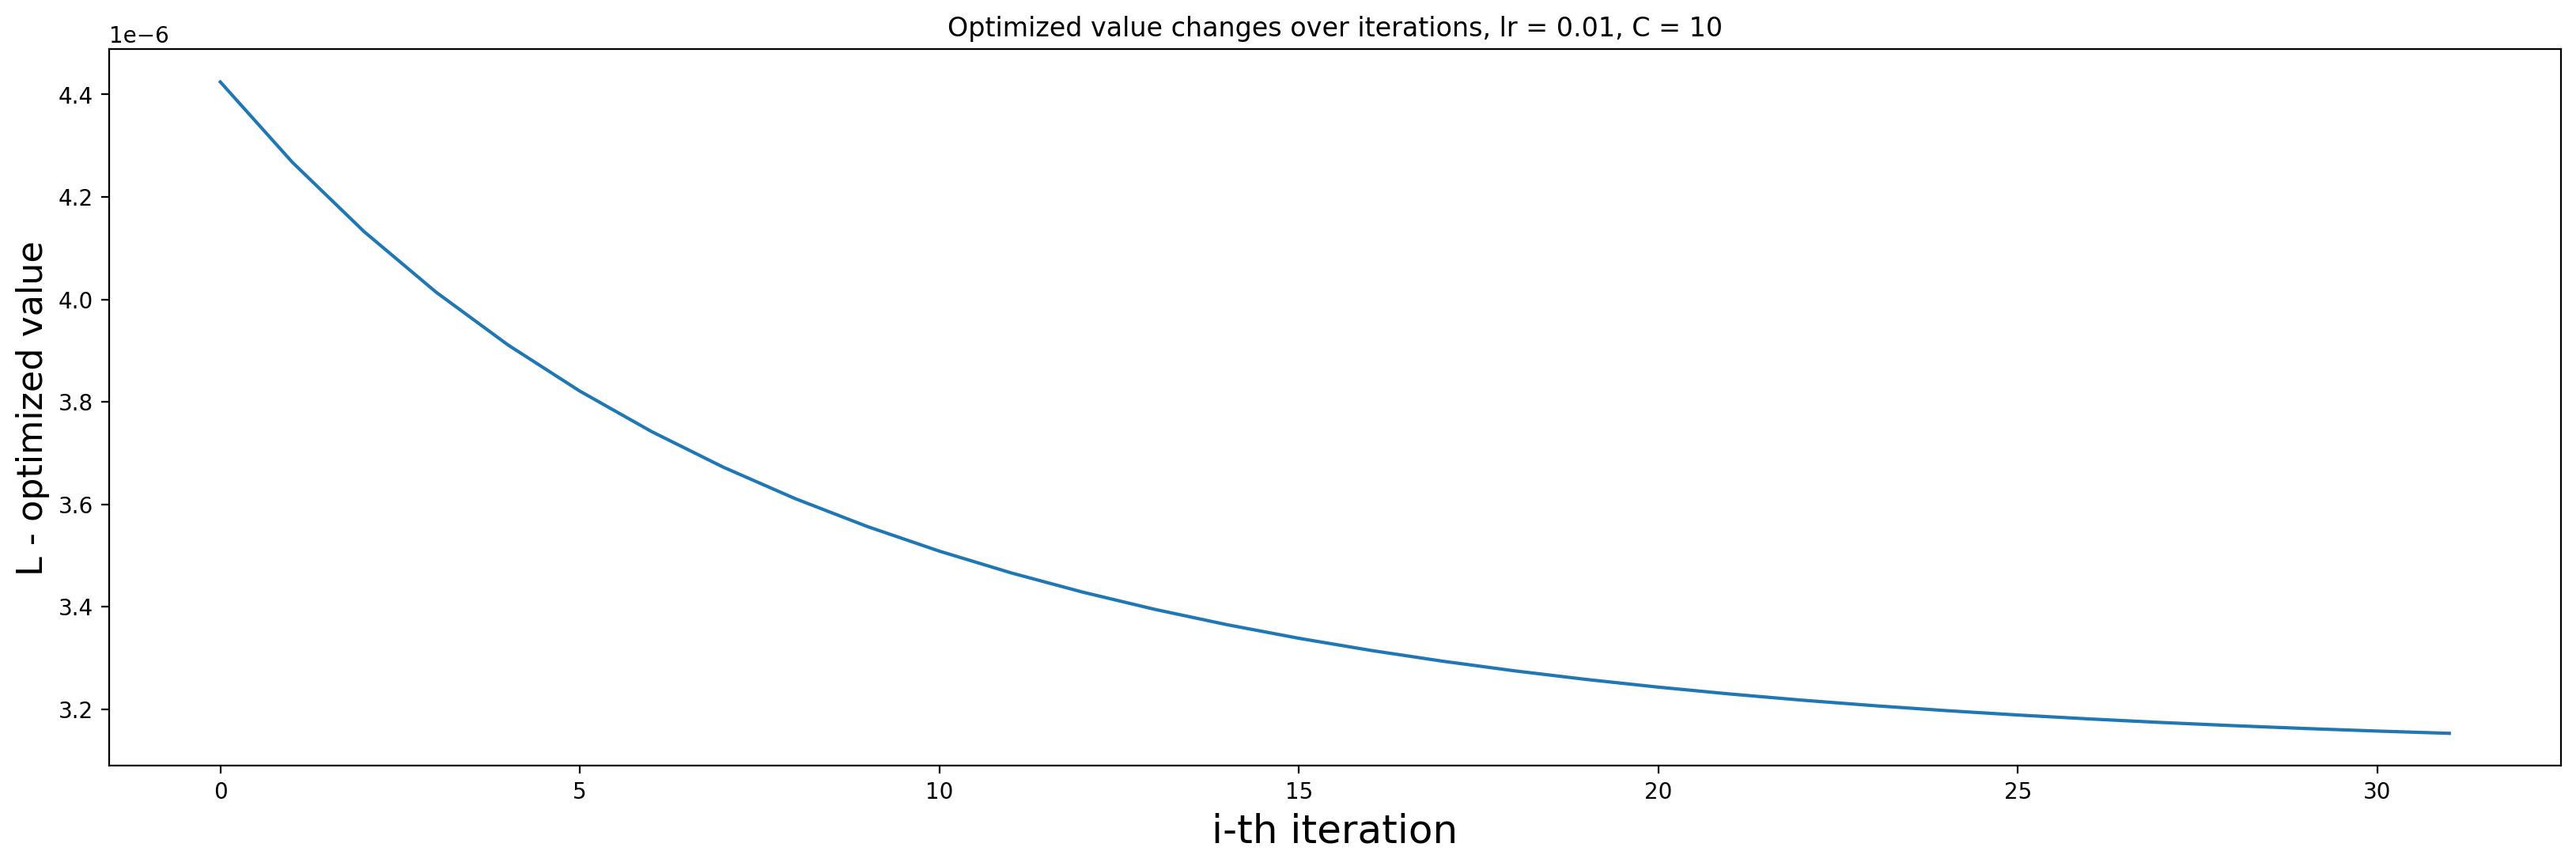

In [252]:
fig = figure(num=None, figsize=(20, 6), dpi=200, facecolor='w', edgecolor='k')
    
plt.plot(optimized_values)

plt.xlabel('i-th iteration', fontsize=18)
plt.ylabel('L - optimized value', fontsize=16)
plt.title("""Optimized value changes over iterations, lr = 0.01, C = 10""")
plt.show()

Тут комментарие никакие не нужны, для градиентного спуска опционал и должен оптимизироваться, в нашем случае мы его минимизурем, что подтверждается на графике.

##### 4. Влияет ли выбор начальной инициализации весов на скорость и качество?

Охо-хо, влияет невероятно сильно, покажу пару примеров

In [235]:
number_of_iterations_for_weight_init = list()
optimized_value_for_weight_init = list()
weights_initializations = np.array(['zeroes', 'random', 'random_second_test', 'random_third_test', 'standart'])

for w in weights_initializations:
    CPHM = CPHazard(hazard_func = hazard_function, weights_init=w, learning_rate = 0.001, C = 10,
                 max_iters = 1000, precision = 0.000001)
    
    CPHM.fit(X_lab_train, y_lab_train, X_lab_train_additional['year of followup'])
    
    number_of_iterations_for_weight_init.append(CPHM.number_of_iterations())
    optimized_value_for_weight_init.append(CPHM.get_optimized_values())
    
    print(str(w) + " weight_init, iterations: " + str(CPHM.number_of_iterations()))
          
number_of_iterations_for_weight_init = np.array(number_of_iterations_for_weight_init)
optimized_value_for_weight_init = np.array(optimized_value_for_weight_init)

zeroes weight_init, iterations: 1
random weight_init, iterations: 105
random_second_test weight_init, iterations: 327
random_third_test weight_init, iterations: 568
standart weight_init, iterations: 1


/home/elephant/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  del sys.path[0]


In [250]:
print(optimized_value_for_weight_init[0])
print(optimized_value_for_weight_init[1][104])
print(optimized_value_for_weight_init[2][326])
print(optimized_value_for_weight_init[3][567])
print(optimized_value_for_weight_init[4])

[[3.17586963e-06]]
[3.16870017e-06]
[3.16326828e-06]
[3.14711622e-06]
[[3.17272477e-06]]


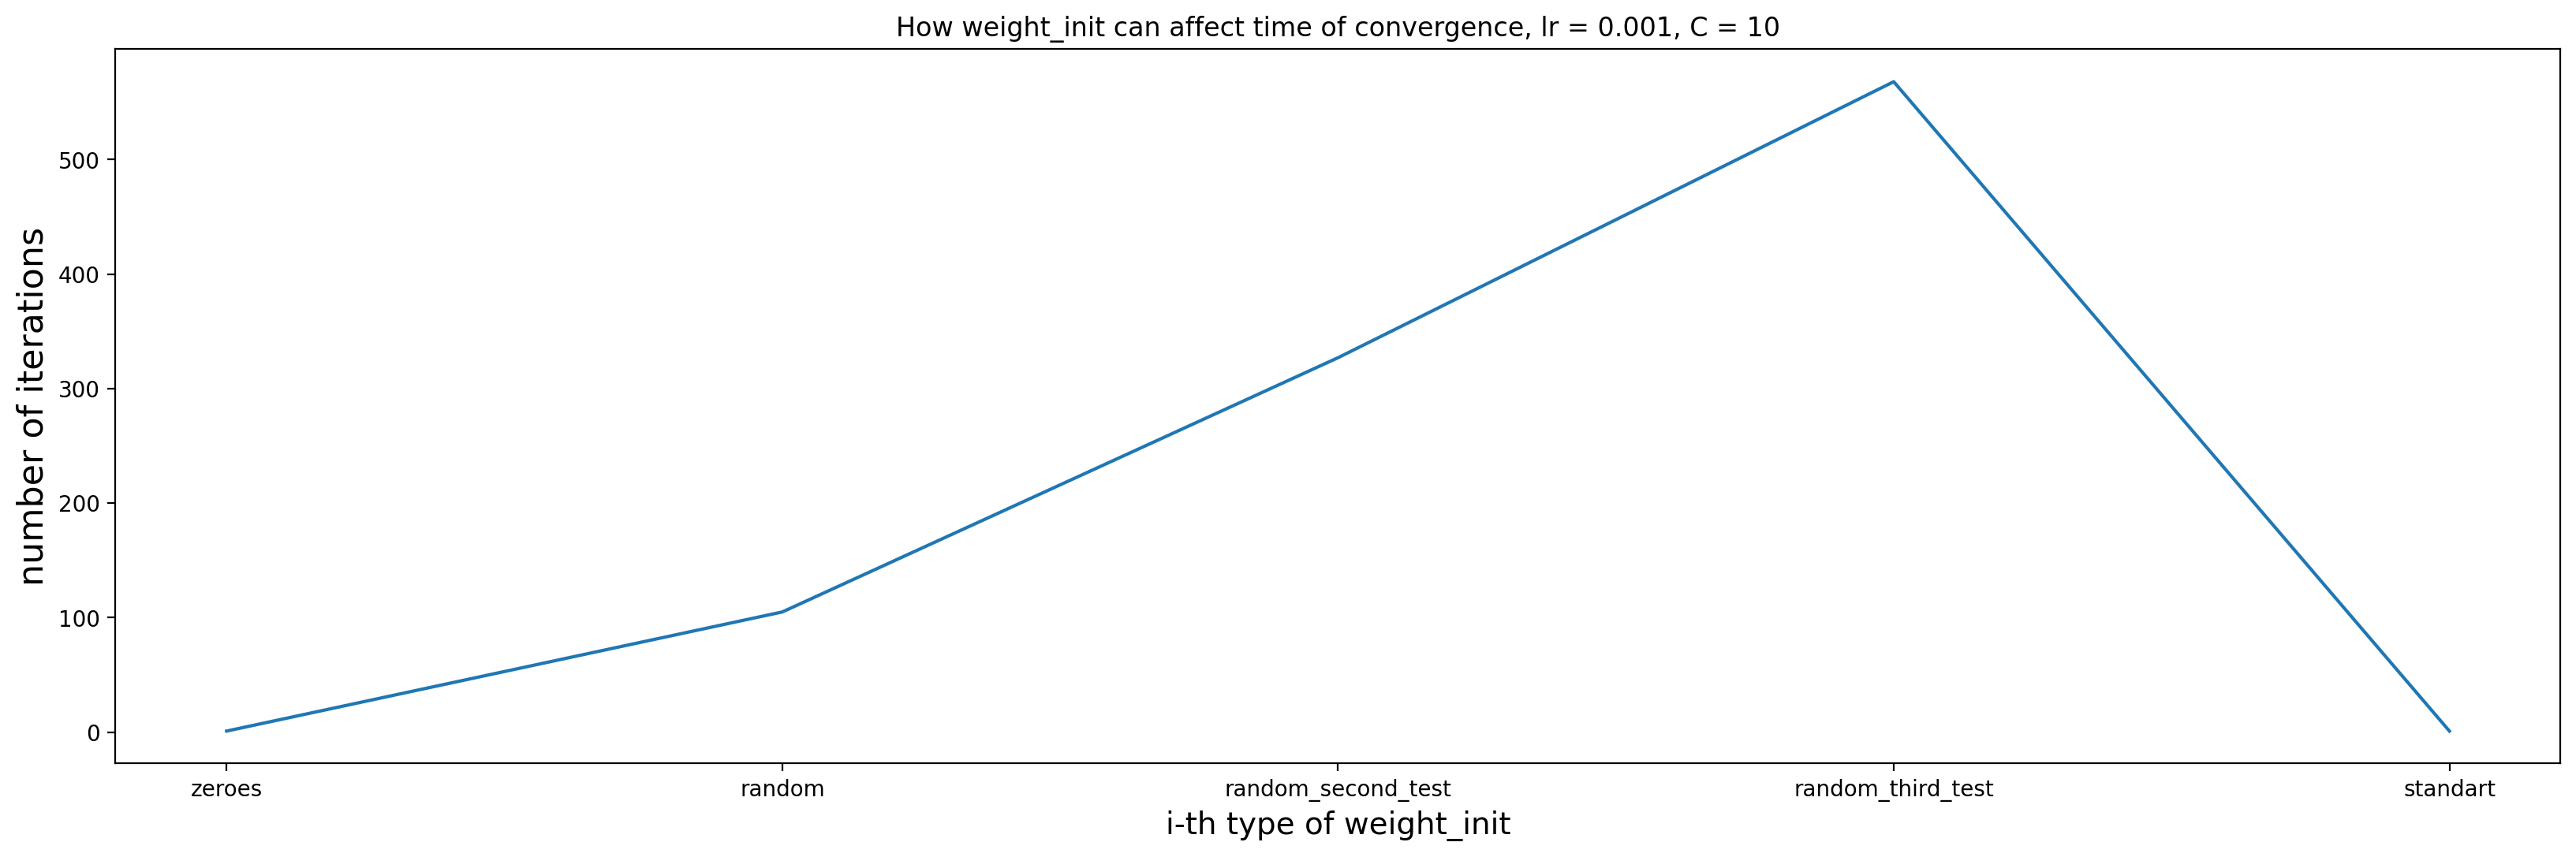

In [236]:
fig = figure(num=None, figsize=(20, 6), dpi=200, facecolor='w', edgecolor='k')
    
plt.xticks(list(range(number_of_iterations_for_weight_init.shape[0])), 
           weights_initializations)
plt.plot(number_of_iterations_for_weight_init)

plt.xlabel('i-th type of weight_init', fontsize=14)
plt.ylabel('number of iterations', fontsize=16)
plt.title("""How weight_init can affect time of convergence, lr = 0.001, C = 10""")
plt.show()

Вотс, то 100 итераций, то 500 итераций, чтобы придти к оптимуму....

For weight init = zeroes optimized value changed from [3.17586963e-06] to [3.17586963e-06]
For weight init = random optimized value changed from [3.27626009e-06] to [3.16870017e-06]
For weight init = random_second_test optimized value changed from [4.88297348e-06] to [3.16326828e-06]
For weight init = random_third_test optimized value changed from [0.00017072] to [3.14711622e-06]
For weight init = standart optimized value changed from [3.17272477e-06] to [3.17272477e-06]
Вывел потому, что пока не сообразил как всё вместе на графике показать, плюс там две точки вообще будут, а не линии, но в общем видно, что сходятся они к значению практически одному и тому же


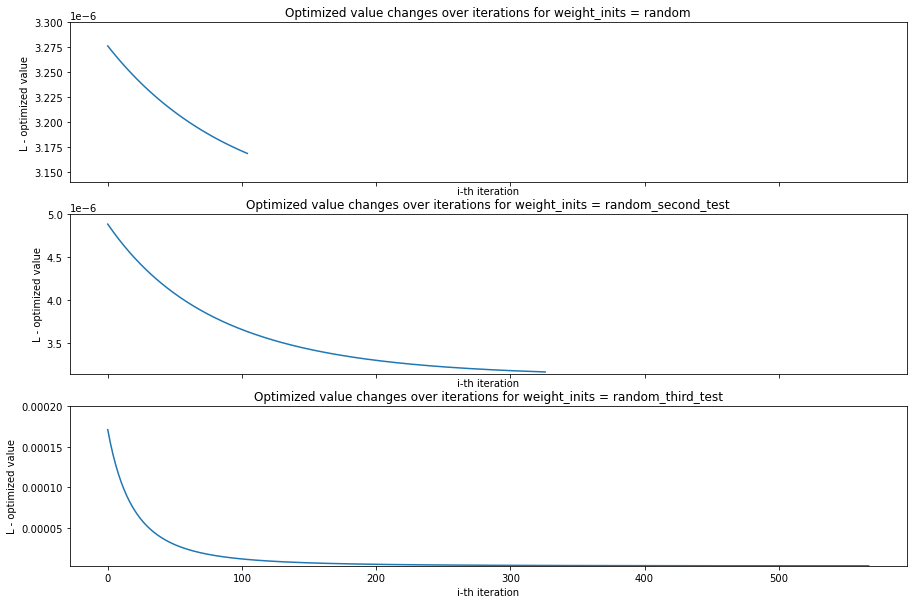

In [311]:
fig, ax = plt.subplots(3, 1, sharex='all', figsize = (15,10))

ax[0].set_ylim(bottom=0.00000314, top=0.0000033)
ax[1].set_ylim(bottom=0.00000314, top=0.000005)
ax[2].set_ylim(bottom=0.00000314, top=0.0002)
for i in range(1,4):
    ax[i - 1].plot(optimized_value_for_weight_init[i], label="weight init = " + str(weights_initializations[i]))
    ax[i - 1].set_xlabel('i-th iteration', fontsize=10)
    ax[i - 1].set_ylabel('L - optimized value', fontsize=10)
    ax[i - 1].set_title("Optimized value changes over iterations for weight_inits = " + 
                        str(weights_initializations[i]))
for i, w in enumerate(weights_initializations):
    print("For weight init = " + str(w) + " optimized value changed from " + str(optimized_value_for_weight_init[i][0]) + " to " + str(optimized_value_for_weight_init[i][-1]))
print("Вывел потому, что пока не сообразил как всё вместе на графике показать, плюс там две точки вообще будут, а не линии, но в общем видно, что сходятся они к значению практически одному и тому же")    

In [312]:
for i in range(5):
    if (0.0000031 < optimized_value_for_weight_init[i][-1] < 0.0000032):
        print("Optimum value for " + str(weights_initializations[i]) + " is in range 3.1e-6 and 3.2e-6")

Optimum value for zeroes is in range 3.1e-6 and 3.2e-6
Optimum value for random is in range 3.1e-6 and 3.2e-6
Optimum value for random_second_test is in range 3.1e-6 and 3.2e-6
Optimum value for random_third_test is in range 3.1e-6 and 3.2e-6
Optimum value for standart is in range 3.1e-6 and 3.2e-6


##### Answer:
На само качество как видно это особенно сильно не влияет, просто подходя из разных мест мы попадаем в чуть разные места, но значения почти не различаются. Так что для нас важна будет только скорость сходимости. НО! Как я и писал в прошлой лабе, если у нас произойдёт угасание градиента сразу и нет регуляризации, то вес останется одинаковым на всех этапах. И конечно же ответ может быть совершенно не оптимальный, если модель не успела сойтись для данного кол-ва итераций, такие примеры я убрал, но видел их уже немало в этой лабе.

Метод градиентного спуска может быть весьма трудозатратен в случае большого размера обучающей выборки. Поэтому обычно используют метод стохастического градиентного спуска, где на каждой итерации выбирается случайный объект из обучающей выборки и обновление весов происходит сразу по этому объекту.

**Задание 9** SGD (1.5 балла)

Реализуйте метод стохастического градиентного спуска (sgd). В этом случае вы можете выбрать наиболее удачный функционал, исходя из предыдущего пункта (с регуляризацией, без), а также схему начальной инициализации весов.

Сравните рассмотренные методы (градиентный спуск и sgd) между собой с точки зрения скорости сходимости и качества.

Посмотрите как влияет размер шага на сходимость (попробуйте 4-5 различных значений)
Исследуйте качество оптимизируемого функционала в зависимости от номера итерации
Выберите лучший размер шага.

В каждом пункте сделайте исчерпывающие выводы, подкреплённые графиками.

In [313]:
import random

In [315]:
class CPHazard_GD(BaseEstimator):
    # weight_init - 'random', 'zeroes', default = 'random' unifrom(0, precision * 100)
    # learning_rate - float, default = 0.01
    # C, коэффициент регуляризации, float, default = 0.0
    # max_iter - int, default = 100
    # precision - float, default = 1e-4
    # hazard_func - func, default = hazard_function defined higher
    
    def __init__(self, hazard_func = hazard_function, weights_init='random', learning_rate = 0.01, C = 0.0,
                 max_iters = 100, precision = 0.0001):
        self.weights_init = weights_init
        self.learning_rate = learning_rate
        self.C = C
        self.max_iters = max_iters
        self.iters = 0
        self.precision = precision
        self.cur_precision = math.inf
        self.weights = np.array(0)
        self.previous_weights = np.array(0)
        self.hazard_func = hazard_func
        self.X = None
        self.y = None
        self.X_last_follow_ups = None
        self.gradient = self.gradient_for_CPHazard
        self.mine_optimized_value_func = self.mine_optimized_value
        self.optimized_values = list()
        
    def fit(self, X, y, last_follow_ups):
        self.X = np.array(X)
        self.y = np.array(y)
        self.X_last_follow_ups = np.array(last_follow_ups)
        
        if (self.weights_init == 'zeroes'):
            self.weights = [0] * X.shape[1]
            
        if (self.weights_init == 'random'):
            self.weights = np.random.uniform(0, self.precision * 100, X.shape[1])
            
        if (self.weights_init == 'random_second_test'):
            self.weights = 10 * np.random.uniform(0, self.precision * 100, X.shape[1])
            
        if (self.weights_init == 'random_third_test'):
            self.weights = 100 * np.random.uniform(0, self.precision * 100, X.shape[1])
            
        if (self.weights_init == 'random_forth_test'):
            self.weights = 300 * np.random.uniform(0, self.precision * 100, X.shape[1])
            
        if (self.weights_init == 'standart'):
            self.weights = np.random.uniform(-1, 1, X.shape[1])
            self.weights /= self.X.shape[0]
            
        self.weights = np.array(self.weights)    
        
        while self.cur_precision > self.precision and self.iters < self.max_iters:
            self.previous_weights = self.weights 
            #print(self.weights)
            self.weights = self.weights - self.learning_rate * self.gradient() - \
                self.learning_rate * self.C * self.weights
            
            self.cur_precision = norm(self.weights - self.previous_weights) 
            #print(self.gradient())
            #print(self.cur_precision)
            self.iters += 1 
            #print("Iteration ", self.iters ,"\nweights are ", self.weights)    
            #print("Iteration ", self.iters)    
            self.optimized_values.append(self.mine_optimized_value_func())
            #print("new value = " + str(self.mine_optimized_value_func()))
            #print(self.optimized_values)
        return self
        
    def predict_proba(self, X_test, t = 5):
        # t - years, to which we predict, default = 5
        print("maybe WRONG IMPL!!!!!! WARNING, actually returnd hazard_COX(t) for each x_i")
        return self.hazard_func(t) * np.exp(np.dot(X_test, self.weights))
        
    def predict(self, X_test, t = 5):
        print("wasn't checked")
        return np.random.choice(1, p = predict_proba(X_test, t))
    
    def number_of_iterations(self):
        return self.iters
    
    def get_optimized_values(self):
        return np.array(self.optimized_values)
    
    def gradient_for_CPHazard(self):
        N = 100
        gradient = 0
        for i in np.arange(N):
            helper = np.exp(self.X[i] @ self.previous_weights)
            
            gradient -= self.X[i] * self.y[i]
        
            second_part = self.hazard_func(self.X_last_follow_ups[i]) * helper
            #print("second check: " + str(np.exp(self.X[i] @ self.previous_weights)))
            
            gradient += (1 - self.y[i]) * second_part * self.X[i] / (1 - second_part)
            #print("second_part =  " + str(((1 - self.y[i]) * second_part * self.X[i] / (1 - second_part))) + " " + \
            #      str(((1 - self.y[i]) * second_part / (1 - second_part))) + " ")
            
            third_part = 0
            for j in np.arange(int(self.X_last_follow_ups[i])):
                third_part_helper = self.hazard_func(j) * helper
                third_part += third_part_helper * self.X[i] / (1 - third_part_helper)
            #print("third_part = " + str(third_part))
            
            gradient += third_part
        return gradient / N
    
    def mine_optimized_value(self):
        N = 100        
        value = 0
        for i in np.arange(N):
            # PREV or CUR WEIGHTS, Can change output for first iterations
            helper = self.X[i] @ self.previous_weights
            helper_exp = np.exp(helper)
            
            first_part = self.y[i] * (np.log(self.hazard_func(self.X_last_follow_ups[i])) + helper)
            #print("optimized first_part = " + str(first_part))
            
            second_part = (1 - self.y[i]) * (np.log(1 - self.hazard_func(self.X_last_follow_ups[i]) * helper_exp))
            #print("optimized second_part = " + str(second_part))
            third_part = 0
            for j in np.arange(int(self.X_last_follow_ups[i])):
                third_part += np.log(1 - self.hazard_func(j) * helper_exp)
            #print("optimized third_part = " + str(third_part))
            #print("part of thrid_part = " + str(self.hazard_func(j) * np.exp(self.X[i] @ self.previous_weights)))
            value += first_part + second_part + third_part
        
        value = -1 * value / N
        return value

In [727]:
class CPHazard_SGD(BaseEstimator):
    # weight_init - 'random', 'zeroes', default = 'random' unifrom(0, precision * 100)
    # learning_rate - float, default = 0.01
    # C, коэффициент регуляризации, float, default = 0.0
    # max_iter - int, default = 100
    # precision - float, default = 1e-4
    # hazard_func - func, default = hazard_function defined higher
    # batch_size = float, default = 10 = 10% of elements
    
    def __init__(self, hazard_func = hazard_function, weights_init='random', learning_rate = 0.01, C = 0.0,
                 max_iters = 100, precision = 0.0001, batch_size = 10):
        self.weights_init = weights_init
        self.learning_rate = learning_rate
        self.C = C
        self.max_iters = max_iters
        self.iters = 0
        self.precision = precision
        self.cur_precision = math.inf
        self.weights = np.array(0)
        self.previous_weights = np.array(0)
        self.hazard_func = hazard_func
        self.X = None
        self.y = None
        self.X_last_follow_ups = None
        self.gradient = self.gradient_for_CPHazard
        self.mine_optimized_value_func = self.mine_optimized_value
        self.optimized_values = list()
        self.batch_size = batch_size
        
    def fit(self, X, y, last_follow_ups):
        self.X = np.array(X)
        self.y = np.array(y)
        self.X_last_follow_ups = np.array(last_follow_ups)
        if (self.weights_init == 'zeroes'):
            self.weights = [0] * X.shape[1]
            
        if (self.weights_init == 'random'):
            self.weights = np.random.uniform(0, self.precision * 100, X.shape[1])
            
        if (self.weights_init == 'random_second_test'):
            self.weights = 10 * np.random.uniform(0, self.precision * 100, X.shape[1])
            
        if (self.weights_init == 'random_third_test'):
            self.weights = 100 * np.random.uniform(0, self.precision * 100, X.shape[1])
            
        if (self.weights_init == 'random_forth_test'):
            self.weights = 300 * np.random.uniform(0, self.precision * 100, X.shape[1])
            
        if (self.weights_init == 'standart'):
            self.weights = np.random.uniform(-1, 1, X.shape[1])
            self.weights /= self.X.shape[0]
            
        self.weights = np.array(self.weights)    
        n = 100
        #print(self.weights)
        
        while self.cur_precision > self.precision and self.iters < self.max_iters:
            self.previous_weights = self.weights 
            #print(self.weights)
            
            indicies = np.array(random.sample(range(0, n), int(n * self.batch_size / 100)))
            #print(indicies)
            #
            self.weights = self.weights - self.learning_rate * self.gradient(indicies) - \
                self.learning_rate * self.C * self.weights
            
            self.cur_precision = norm(self.weights - self.previous_weights) 
            #print(self.gradient())
            #print(self.cur_precision)
            self.iters += 1 
            #print("Iteration ", self.iters ,"\nweights are ", self.weights)    
            #print("Iteration ", self.iters)    
            self.optimized_values.append(self.mine_optimized_value_func(indicies))
            #print("new value = " + str(self.mine_optimized_value_func()))
            #print(self.optimized_values)
        return self
        
    def predict_proba(self, X_test, t = 5):
        # t - years, to which we predict, default = 5
        return self.hazard_func(t) * np.exp(np.dot(X_test, self.weights))
        
    def predict(self, X_test, t = 5):
        return np.random.choice(1, p = predict_proba(X_test, t))
    
    def number_of_iterations(self):
        return self.iters
    
    def get_optimized_values(self):
        return np.array(self.optimized_values)
    
    def gradient_for_CPHazard(self, batch_indexes):
        N = batch_indexes.shape[0]
        gradient = 0
        for i in batch_indexes:
            helper = np.exp(self.X[i] @ self.previous_weights)
            # print(helper)
            gradient -= self.X[i] * self.y[i]
        
            second_part = self.hazard_func(self.X_last_follow_ups[i]) * helper
            #print("second check: " + str(np.exp(self.X[i] @ self.previous_weights)))
            #print(self.hazard_func(self.X_last_follow_ups[i]))
            #print(second_part.shape)
            gradient += (1 - self.y[i]) * second_part * self.X[i] / (1 - second_part)
            #print("second_part =  " + str(((1 - self.y[i]) * second_part * self.X[i] / (1 - second_part))) + " " + \
            #      str(((1 - self.y[i]) * second_part / (1 - second_part))) + " ")
            
            third_part = 0
            for j in np.arange(int(self.X_last_follow_ups[i])):
                third_part_helper = self.hazard_func(j) * helper
                third_part += third_part_helper * self.X[i] / (1 - third_part_helper)
            #print("third_part = " + str(third_part))
            
            gradient += third_part
        return gradient / N
    
    def mine_optimized_value(self, batch_indexes):
        N = 100
        value = 0
        for i in np.arange(N):
            # PREV or CUR WEIGHTS, Can change output for first iterations
            helper = self.X[i] @ self.previous_weights
            helper_exp = np.exp(helper)
            
            first_part = self.y[i] * (np.log(self.hazard_func(self.X_last_follow_ups[i])) + helper)
            #print("optimized first_part = " + str(first_part))
            
            second_part = (1 - self.y[i]) * (np.log(1 - self.hazard_func(self.X_last_follow_ups[i]) * helper_exp))
            #print("optimized second_part = " + str(second_part))
            third_part = 0
            for j in np.arange(int(self.X_last_follow_ups[i])):
                third_part += np.log(1 - self.hazard_func(j) * helper_exp)
            #print("optimized third_part = " + str(third_part))
            #print("part of thrid_part = " + str(self.hazard_func(j) * np.exp(self.X[i] @ self.previous_weights)))
            value += first_part + second_part + third_part
        
        value = -1 * value / N
        return value

In [382]:
CPHM_SGD = CPHazard_SGD(hazard_func = hazard_function, weights_init='random', learning_rate = 0.01, C = 10,
                 max_iters = 1000, precision = 0.0000002, batch_size = 5)
CPHM_SGD.fit(X_lab_train, y_lab_train, X_lab_train_additional['year of followup'])
print(CPHM_SGD.number_of_iterations())

86


In [383]:
CPHM_GD = CPHazard_GD(hazard_func = hazard_function, weights_init='random', learning_rate = 0.01, C = 10,
                 max_iters = 1000, precision = 0.0000002)
CPHM_GD.fit(X_lab_train, y_lab_train, X_lab_train_additional['year of followup'])
print(CPHM_GD.number_of_iterations())

39


Сравните рассмотренные методы (градиентный спуск и sgd) между собой с точки зрения скорости сходимости и качества.

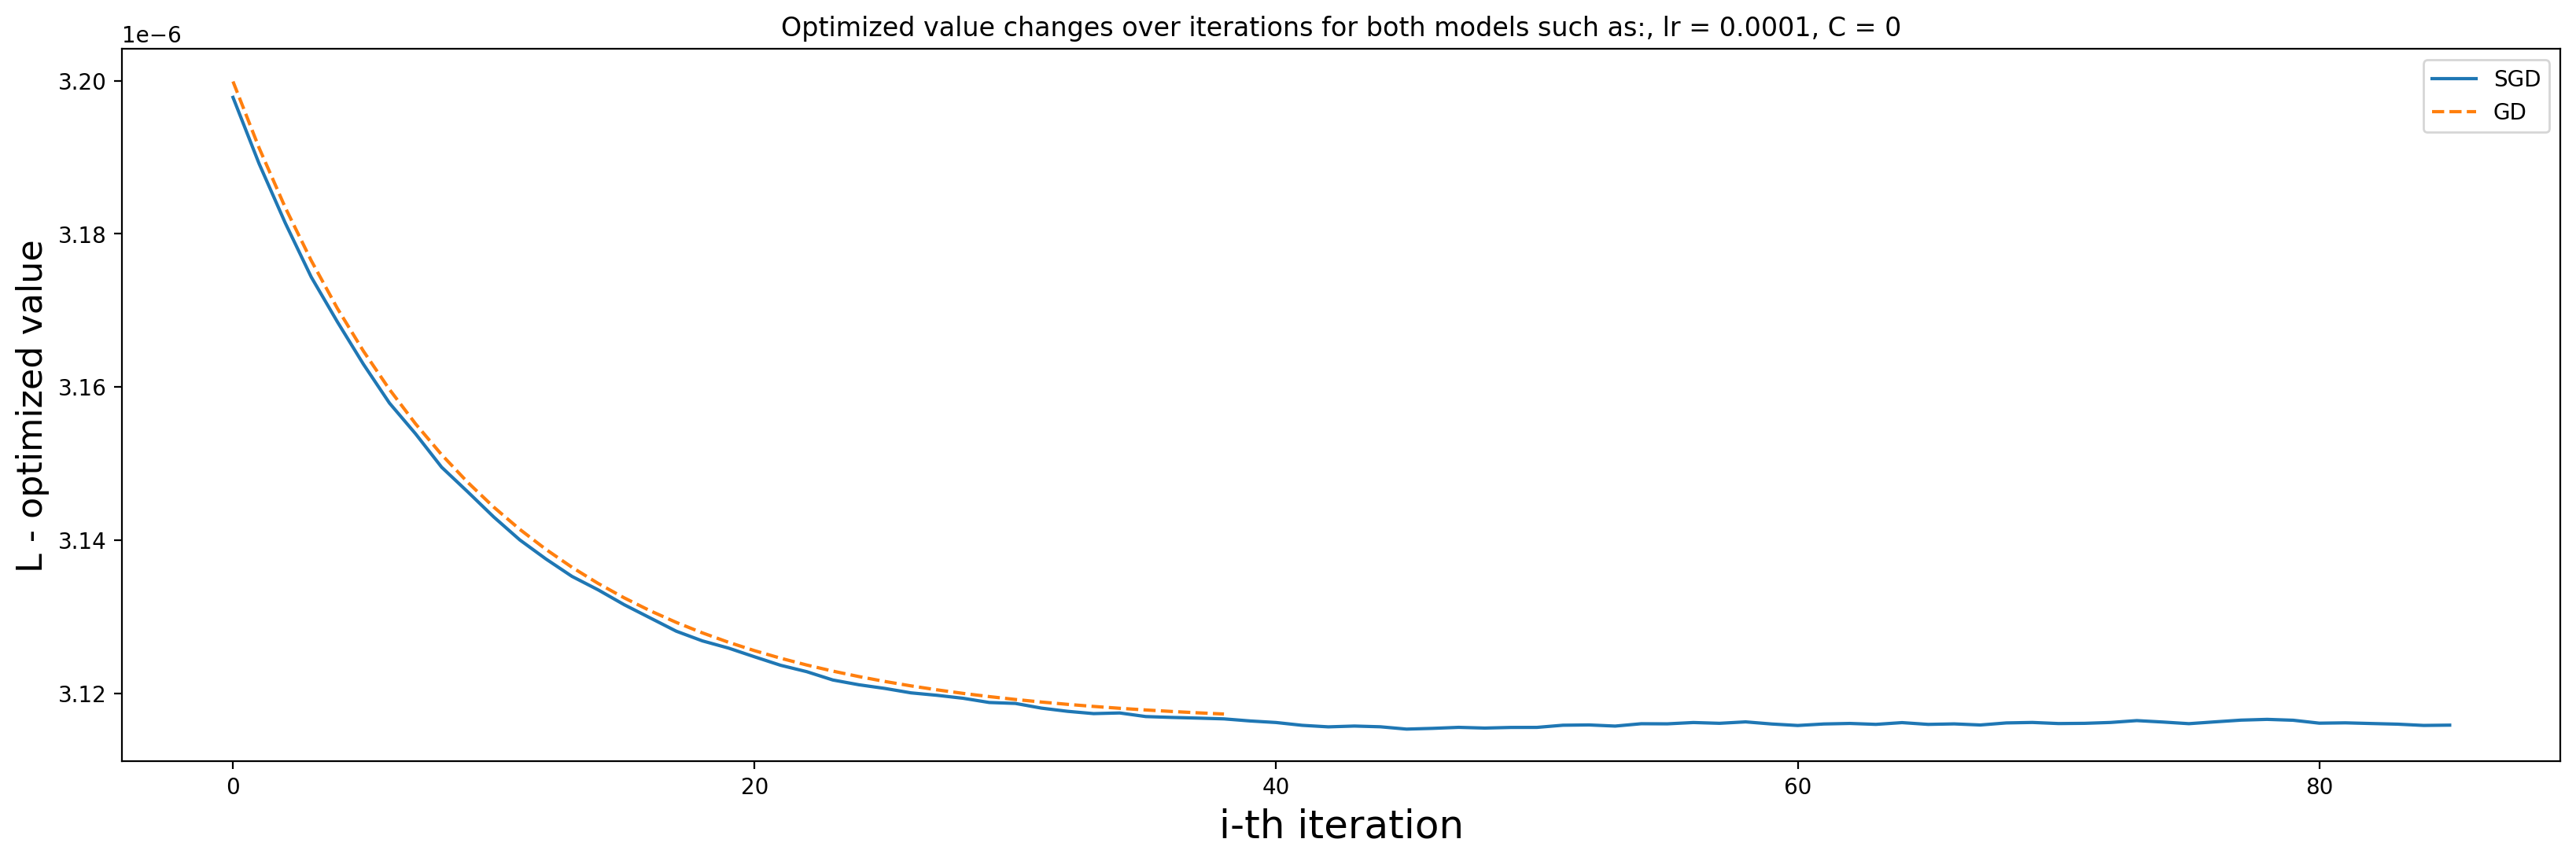

In [384]:
optimized_values_for_SGD = CPHM_SGD.get_optimized_values()
optimized_values_for_GD = CPHM_GD.get_optimized_values()

fig = figure(num=None, figsize=(20, 6), dpi=200, facecolor='w', edgecolor='k')

max_iters = max(optimized_values_for_SGDCPHazardModel.shape[0], optimized_values_for_CPHazardHonest.shape[0])


plt.plot(np.array(range(optimized_values_for_SGD.shape[0])),
         optimized_values_for_SGD, '-', label='SGD')
plt.plot(np.array(range(optimized_values_for_GD.shape[0])),
         optimized_values_for_GD, '--', label='GD')
plt.legend(loc='best')
plt.xlabel('i-th iteration', fontsize=18)
plt.ylabel('L - optimized value', fontsize=16)
plt.title("""Optimized value changes over iterations for both models such as:, lr = 0.0001, C = 0""")

plt.show()

На вид они сильно похоже, но это не совсем так :)

Посмотрите как влияет размер шага на сходимость (попробуйте 4-5 различных значений) Исследуйте качество оптимизируемого функционала в зависимости от номера итерации Выберите лучший размер шага.

In [400]:
number_of_iterations_for_SGD_lr = list()
optimized_val_for_SGD_lr = list()
lr_values = np.array([0.05, 0.01, 0.0075, 0.005, 0.0025, 0.001])
for i, lr in enumerate(lr_values):
    sgd = CPHazard_SGD(hazard_func = hazard_function, weights_init='standart',
                           learning_rate = lr, C = 10,
                           max_iters = 1000, precision = 0.0000002, batch_size = 5)
    sgd.fit(X_lab_train, y_lab_train, X_lab_train_additional['year of followup'])
    number_of_iterations_for_SGD_lr.append(sgd.number_of_iterations())
    optimized_val_for_SGD_lr.append(sgd.get_optimized_values())
    print(str(lr) + " lr, optimized val SGD: " + str(optimized_val_for_SGD_lr[i][-1]) + " iterations: " +\
         str(sgd.number_of_iterations()))
          
number_of_iterations_for_SGD_lr = np.array(number_of_iterations_for_SGD_lr)
optimized_val_for_SGD_lr = np.array(optimized_val_for_SGD_lr)

0.05 lr, optimized val SGD: [3.11671824e-06] iterations: 1000
0.01 lr, optimized val SGD: [3.11488721e-06] iterations: 85
0.0075 lr, optimized val SGD: [3.11632531e-06] iterations: 65
0.005 lr, optimized val SGD: [3.11889392e-06] iterations: 55
0.0025 lr, optimized val SGD: [3.12145246e-06] iterations: 94
0.001 lr, optimized val SGD: [3.13053536e-06] iterations: 133


/home/elephant/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


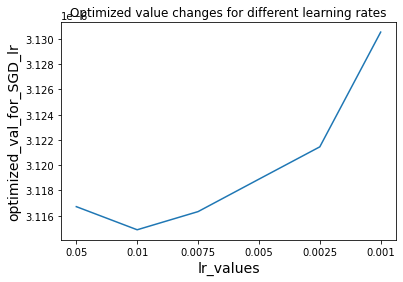

In [401]:
plt.xticks(range(lr_values.shape[0]), lr_values)
plt.plot([optimized_val_for_SGD_lr[i][-1] for i in range(optimized_val_for_SGD_lr.shape[0])])      
plt.xlabel('lr_values', fontsize=14)
plt.ylabel('optimized_val_for_SGD_lr', fontsize=14)
plt.title("""Optimized value changes for different learning rates""")     

plt.show()

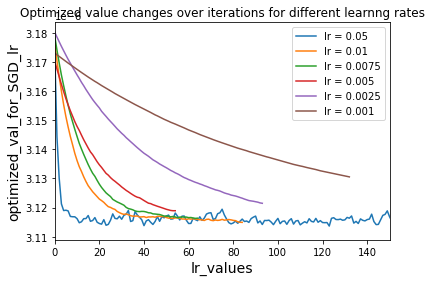

In [402]:
plt.xlim(right = 150)
for i in range(optimized_val_for_SGD_lr.shape[0]):
    plt.plot(np.array(range(optimized_val_for_SGD_lr[i].shape[0])),
             optimized_val_for_SGD_lr[i], '-', label='lr = ' + str(lr_values[i]))
plt.legend(loc='best')
plt.xlabel('lr_values', fontsize=14)
plt.ylabel('optimized_val_for_SGD_lr', fontsize=14)
plt.title("""Optimized value changes over iterations for different learnng rates""")
plt.show()

##### Answer:
Как было видно и выше, для lr = 0.05 наш алгоритм даже не сходится на 1000 итераций, хотя там видимо вообще колво итераций не сильно поможет)) слишком большой шаг получается для него с нашей то точностью стох град спуска. в общем, видно, что не которые lr выдают результаты похуже, и заканчивают свою работу по precision. Так что я бы брал дальше 0.0075, это лушее качество при меньших итерациях среди всех.

Впорос: а почему так происходит?

Да в общем то всё просто, картинка снизу это и объясняет, что мы не обязательно попадает в сам оптимум, чтобы сойтись, мы просто в окрестность попадаем, совсем рядышком и нам норм, мы работу сделали :)

Между обновлением вектора весов по всей выборке и на одном объекте есть промежуточный подход — выбирать некоторое случайное подмножество объектов и обновлять веса по нему. Такой подход называется mini-batch. Мы не будем реализовывать этот подход в данной работе, однако иногда его бывает осмысленно использовать на практике. 

Один из недостатков sgd состоит в том, что он может не доходить до локального оптимального решения, а осциллировать в окрестности. 

![](http://sebastianruder.com/content/images/2015/12/without_momentum.gif)

Для решения этой проблемы существуют методы, позволяющие устранить этот недостаток, а также ускорить сходимость. Рассмотрим некоторые из них.

![](http://nghenglim.github.io/images/2015061300.png)

### Momentum

Этот метод позволяет направить sgd в нужной размерности и уменьшить осцилляцию. 

В общем случае он будет выглядеть следующим образом: 

$$ v_t = \gamma v_{t - 1} + \eta \nabla_{w}{J(w)}$$
$$ w = w - v_t$$

где

 - $w$ — вектор параметров
 - $J$ — оптимизируемый функционал
 - $\gamma$ — momentum term (обычно выбирается 0.9)
 
### Adagrad 

Одной из сложностей является выбор размера шага (*learning rate*). Основное отличие данного метода от SGD состоит в том что размер шага определяется для каждого параметра индивидуально. Этот метод хорошо работает с разреженным данным большого объема. 

Обозначим градиент по параметру $w_i$ на итерации $t$ как $g_{t,i} = \nabla_{w}J(w_i)$. 

В случае sgd обновление параметра $w_i$ будет выглядеть следующим образом:

$$ w_{t+1, i} = w_{t, i} - \eta \cdot g_{t,i}$$

А в случае Adagrad общий шаг $\eta$ нормируется на посчитанные ранее градиенты для данного параметра:

$$ w_{t+1, i} = w_{t, i} - \dfrac{\eta}{\sqrt{G_{t,ii} + \varepsilon}} \cdot g_{t,i}$$

где $G_t$ — диагональная матрица, где каждый диагональный элемент $i,i$ — сумма квадратов градиентов для $w_{i}$ до $t$-ой итерации. $\varepsilon$ — гиперпараметр, позволяющий избежать деления на 0 (обычно выбирается около *1e-8*).

Так как матрица $G_t$ диагональна, в векторном виде это будет выглядеть следующим образом (здесь $\odot$ — матричное умножение):

$$ w_{t+1} = w_{t} - \dfrac{\eta}{\sqrt{G_t + \varepsilon}} \odot g_t $$

### Adadelta

Adadelta, в отличии от Adagrad, рассматривает не все предыдущие значения градиентов, а только последние $k$. Кроме того, сумма градиентов определяется как уменьшающееся среднеее всех предыдущих квадратов градиентов. Текущее среднее $E[g^2]_t$ на итерации $t$ будет вглядеть следующим образом:

$$ E[g^2]_t = \gamma E[g^2]_{t-1} + (1-\gamma)g_t^2 $$

здесь $\gamma$ аналогична гиперпараметру из метода Momentum.

Тогда обновление весов можно записать следующим образом:

$$ w_{t+1} = w_{t} - \dfrac{\eta}{\sqrt{E[g^2]_t + \varepsilon}} g_t $$ 

Перепишем это немного по-другому:

$$ w_{t+1} = w_{t} + \Delta w_t$$ 
$$\Delta w_t = - \dfrac{\eta}{\sqrt{E[g^2]_t + \varepsilon}} g_t $$ 

Аналогично среднему для градиентов определим среднее для параметров $w$:

$$ E[\Delta w^2]_t = \gamma E[\Delta w^2]_{t-1} + (1-\gamma)\Delta w^2 $$

Введем обозначение $RMS[p]_t = \sqrt{E[p]_t + \varepsilon}$

Тогда Adadelta выглядит следующим образом:

$$\Delta w_t = - \dfrac{RMS[\Delta w^2]}{RMS[ga^2]} g_t $$ 
$$ w_{t+1} = w_{t} + \Delta w_t$$ 


Более подробно об этих и других способах оптимизации можно прочитать:
 - [здесь](http://sebastianruder.com/optimizing-gradient-descent/index.html#gradientdescentoptimizationalgorithms) очень хорошее описание различных способов оптимизации, в этом задании мы опираемся на терминологию из данной статьи
 - статья про [momentum](https://pdfs.semanticscholar.org/97da/c94ffd7a7ac09a4218848300cc7e98569d77.pdf)
 - оригинальная статья про [adagrad](http://www.jmlr.org/papers/volume12/duchi11a/duchi11a.pdf)
 - оригинальная статья про [adadelta](http://arxiv.org/pdf/1212.5701v1.pdf)
 - википедия про [momentum](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Momentum) и [adagrad](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#AdaGrad)
 - [визуализация](http://imgur.com/a/Hqolp) разных способов оптимизации

**Задание 10** Реализуйте метод оптимизации *Momentum* (1 балл) и 

**Задание 11** Реализуйте один из *Adagrad*/*Adadelta* (1.5 балла).

В заданиях 10, 11:
- Сравните оба метода с классическим sgd с точки зрения скорости сходимости.
- Посмотрите как значение гиперпараметра $\gamma$ влияет на скорость сходимости и качество в методе *Momentum*.

Постройте графики и опишите полученные результаты.

Дало ли преимущество использование адаптивного шага в методе *Adagrad*/*Adadelta*?

In [718]:
class CPHazard_SGD_Momentum(BaseEstimator):
    # weight_init - 'random', 'zeroes', default = 'random' unifrom(0, precision * 100)
    # learning_rate - float, default = 0.01
    # C, коэффициент регуляризации, float, default = 0.0
    # max_iter - int, default = 100
    # precision - float, default = 1e-4
    # hazard_func - func, default = hazard_function defined higher
    # batch_size = float, default = 10 = 10% of elements
    # momentum_term default = 0.9
    
    def __init__(self, hazard_func = hazard_function, weights_init='random', learning_rate = 0.01, C = 0.0,
                 max_iters = 100, precision = 0.0001, batch_size = 10, momentum_term = 0.9):
        self.weights_init = weights_init
        self.learning_rate = learning_rate
        self.C = C
        self.max_iters = max_iters
        self.iters = 0
        self.precision = precision
        self.cur_precision = math.inf
        self.weights = np.array(0)
        self.previous_weights = np.array(0)
        self.hazard_func = hazard_func
        self.X = None
        self.y = None
        self.X_last_follow_ups = None
        self.gradient = self.gradient_for_CPHazard
        self.mine_optimized_value_func = self.mine_optimized_value
        self.optimized_values = list()
        self.batch_size = batch_size
        self.momentum_term = momentum_term
        self.previous_momentum = 0
        
    def fit(self, X, y, last_follow_ups):
        self.X = np.array(X)
        self.y = np.array(y)
        self.X_last_follow_ups = np.array(last_follow_ups)
        self.N = self.X.shape[0]
        if (self.weights_init == 'zeroes'):
            self.weights = [0] * X.shape[1]
            
        if (self.weights_init == 'random'):
            self.weights = np.random.uniform(0, self.precision * 100, X.shape[1])
            
        if (self.weights_init == 'random_second_test'):
            self.weights = 10 * np.random.uniform(0, self.precision * 100, X.shape[1])
            
        if (self.weights_init == 'random_third_test'):
            self.weights = 100 * np.random.uniform(0, self.precision * 100, X.shape[1])
            
        if (self.weights_init == 'random_forth_test'):
            self.weights = 300 * np.random.uniform(0, self.precision * 100, X.shape[1])
            
        if (self.weights_init == 'standart'):
            self.weights = np.random.uniform(-1, 1, X.shape[1])
            self.weights /= self.X.shape[0]
            
        self.weights = np.array(self.weights)    
        n = 100
        #print(self.weights)
        
        while self.cur_precision > self.precision and self.iters < self.max_iters:
            self.previous_weights = self.weights 
            #print(self.weights)
            
            indicies = np.array(random.sample(range(0, n), int(n * self.batch_size / 100)))
            #print(indicies)
            #
            ''' usual sgd
            self.weights = self.weights - self.learning_rate * self.gradient(indicies) - \
                self.learning_rate * self.C * self.weights
            '''
            # momentum sgd
            cur_momentum = self.momentum_term * self.previous_momentum + self.learning_rate * self.gradient(indicies)
            self.weights = self.weights - cur_momentum
            self.previous_momentum = cur_momentum
            
            self.cur_precision = norm(self.weights - self.previous_weights) 
            #print(self.gradient())
            #print(self.cur_precision)
            self.iters += 1 
            #print("Iteration ", self.iters ,"\nweights are ", self.weights)    
            #print("Iteration ", self.iters)    
            self.optimized_values.append(self.mine_optimized_value_func(indicies))
            #print("new value = " + str(self.mine_optimized_value_func()))
            #print(self.optimized_values)
        return self
        
    def predict_proba(self, X_test, t = 5):
        # t - years, to which we predict, default = 5
        print("maybe WRONG IMPL!!!!!! WARNING, actually returnd hazard_COX(t) for each x_i")
        return self.hazard_func(t) * np.exp(np.dot(X_test, self.weights))
        
    def predict(self, X_test, t = 5):
        print("wasn't checked")
        return np.random.choice(1, p = predict_proba(X_test, t))
    
    def number_of_iterations(self):
        return self.iters
    
    def get_optimized_values(self):
        return np.array(self.optimized_values)
    
    def gradient_for_CPHazard(self, batch_indexes):
        N = batch_indexes.shape[0]
        gradient = 0
        for i in batch_indexes:
            helper = np.exp(self.X[i] @ self.previous_weights)
            # print(helper)
            gradient -= self.X[i] * self.y[i]
        
            second_part = self.hazard_func(self.X_last_follow_ups[i]) * helper
            #print("second check: " + str(np.exp(self.X[i] @ self.previous_weights)))
            #print(self.hazard_func(self.X_last_follow_ups[i]))
            #print(second_part.shape)
            gradient += (1 - self.y[i]) * second_part * self.X[i] / (1 - second_part)
            #print("second_part =  " + str(((1 - self.y[i]) * second_part * self.X[i] / (1 - second_part))) + " " + \
            #      str(((1 - self.y[i]) * second_part / (1 - second_part))) + " ")
            
            third_part = 0
            for j in np.arange(int(self.X_last_follow_ups[i])):
                third_part_helper = self.hazard_func(j) * helper
                third_part += third_part_helper * self.X[i] / (1 - third_part_helper)
            #print("third_part = " + str(third_part))
            
            gradient += third_part
        return gradient / N
    
    def mine_optimized_value(self, batch_indexes):
        N = 100
        value = 0
        for i in np.arange(N):
            # PREV or CUR WEIGHTS, Can change output for first iterations
            helper = self.X[i] @ self.previous_weights
            helper_exp = np.exp(helper)
            
            first_part = self.y[i] * (np.log(self.hazard_func(self.X_last_follow_ups[i])) + helper)
            #print("optimized first_part = " + str(first_part))
            
            second_part = (1 - self.y[i]) * (np.log(1 - self.hazard_func(self.X_last_follow_ups[i]) * helper_exp))
            #print("optimized second_part = " + str(second_part))
            third_part = 0
            for j in np.arange(int(self.X_last_follow_ups[i])):
                third_part += np.log(1 - self.hazard_func(j) * helper_exp)
            #print("optimized third_part = " + str(third_part))
            #print("part of thrid_part = " + str(self.hazard_func(j) * np.exp(self.X[i] @ self.previous_weights)))
            value += first_part + second_part + third_part
        
        value = -1 * value / N
        return value

In [896]:
class CPHazard_SGD_Adagrad(BaseEstimator):
    # weight_init - 'random', 'zeroes', default = 'random' unifrom(0, precision * 100)
    # learning_rate - float, default = 0.01
    # C, коэффициент регуляризации, float, default = 0.0
    # max_iter - int, default = 100
    # precision - float, default = 1e-4
    # hazard_func - func, default = hazard_function defined higher
    # batch_size = float, default = 10 = 10% of elements
    
    def __init__(self, hazard_func = hazard_function, weights_init='random', learning_rate = 0.01, C = 0.0,
                 max_iters = 100, precision = 0.0001, batch_size = 10, adagrad_epsilon = 1 / (10 ** 8)):
        self.weights_init = weights_init
        self.learning_rate = learning_rate
        self.C = C
        self.max_iters = max_iters
        self.iters = 0
        self.precision = precision
        self.cur_precision = math.inf
        self.weights = np.array(0)
        self.previous_weights = np.array(0)
        self.hazard_func = hazard_func
        self.X = None
        self.y = None
        self.X_last_follow_ups = None
        self.gradient = self.gradient_for_CPHazard
        self.mine_optimized_value_func = self.mine_optimized_value
        self.optimized_values = list()
        self.batch_size = batch_size
        self.adagrad_epsilon = adagrad_epsilon
        self.adagrad_matrix = None
        
    def fit(self, X, y, last_follow_ups):
        self.X = np.array(X)
        self.y = np.array(y)
        self.X_last_follow_ups = np.array(last_follow_ups)
        self.N = self.X.shape[0]
        if (self.weights_init == 'zeroes'):
            self.weights = [0] * X.shape[1]
            
        if (self.weights_init == 'random'):
            self.weights = np.random.uniform(0, self.precision * 100, X.shape[1])
            
        if (self.weights_init == 'random_second_test'):
            self.weights = 10 * np.random.uniform(0, self.precision * 100, X.shape[1])
            
        if (self.weights_init == 'random_third_test'):
            self.weights = 100 * np.random.uniform(0, self.precision * 100, X.shape[1])
            
        if (self.weights_init == 'random_forth_test'):
            self.weights = 300 * np.random.uniform(0, self.precision * 100, X.shape[1])
            
        if (self.weights_init == 'standart'):
            self.weights = np.random.uniform(-1, 1, X.shape[1])
            self.weights /= self.X.shape[0]
            
        self.weights = np.array(self.weights)    
        n = 100
        #print(self.weights)
        self.adagrad_matrix = np.array([np.array([0.0] * self.X.shape[1])] * self.X.shape[1])
        self.adagrad_matrix += self.adagrad_epsilon
        #print(self.adagrad_matrix)
        while self.cur_precision > self.precision and self.iters < self.max_iters:
            self.previous_weights = self.weights 
            #print(self.weights)
            
            indicies = np.array(random.sample(range(0, n), int(n * self.batch_size / 100)))
            #print(indicies)
            #
            '''
            usual sgd
            self.weights = self.weights - self.learning_rate * self.gradient(indicies) - \
                self.learning_rate * self.C * self.weights
            '''
            # adagrad
            cur_gradient = self.gradient(indicies)
            #print(cur_gradient)
            self.weights = self.weights - (self.learning_rate / np.sqrt(self.adagrad_matrix)) \
                                          @ cur_gradient
            #print((self.learning_rate / np.sqrt(self.adagrad_matrix)) \
            #                              @ cur_gradient)
            for i in range(self.adagrad_matrix.shape[0]):
                self.adagrad_matrix[i][i] += cur_gradient[i] ** 2      
            
            self.cur_precision = norm(self.weights - self.previous_weights) 
            #print(self.gradient())
            #print(self.cur_precision)
            self.iters += 1 
            #print("Iteration ", self.iters ,"\nweights are ", self.weights)    
            #print("Iteration ", self.iters)    
            self.optimized_values.append(self.mine_optimized_value_func(indicies))
            #print("new value = " + str(self.mine_optimized_value_func()))
            #print(self.optimized_values)
        return self
        
    def predict_proba(self, X_test, t = 5):
        # t - years, to which we predict, default = 5
        print("maybe WRONG IMPL!!!!!! WARNING, actually returnd hazard_COX(t) for each x_i")
        return self.hazard_func(t) * np.exp(np.dot(X_test, self.weights))
        
    def predict(self, X_test, t = 5):
        print("wasn't checked")
        return np.random.choice(1, p = predict_proba(X_test, t))
    
    def number_of_iterations(self):
        return self.iters
    
    def get_optimized_values(self):
        return np.array(self.optimized_values)
    
    def gradient_for_CPHazard(self, batch_indexes):
        N = batch_indexes.shape[0]
        gradient = 0
        for i in batch_indexes:
            helper = np.exp(self.X[i] @ self.previous_weights)
            # print(helper)
            gradient -= self.X[i] * self.y[i]
        
            second_part = self.hazard_func(self.X_last_follow_ups[i]) * helper
            #print("second check: " + str(np.exp(self.X[i] @ self.previous_weights)))
            #print(self.hazard_func(self.X_last_follow_ups[i]))
            #print(second_part.shape)
            gradient += (1 - self.y[i]) * second_part * self.X[i] / (1 - second_part)
            #print("second_part =  " + str(((1 - self.y[i]) * second_part * self.X[i] / (1 - second_part))) + " " + \
            #      str(((1 - self.y[i]) * second_part / (1 - second_part))) + " ")
            
            third_part = 0
            for j in np.arange(int(self.X_last_follow_ups[i])):
                third_part_helper = self.hazard_func(j) * helper
                third_part += third_part_helper * self.X[i] / (1 - third_part_helper)
            #print("third_part = " + str(third_part))
            
            gradient += third_part
        return gradient / N
    
    def mine_optimized_value(self, batch_indexes):
        N = 100
        value = 0
        for i in np.arange(N):
            # PREV or CUR WEIGHTS, Can change output for first iterations
            helper = self.X[i] @ self.previous_weights
            helper_exp = np.exp(helper)
            
            first_part = self.y[i] * (np.log(self.hazard_func(self.X_last_follow_ups[i])) + helper)
            #print("optimized first_part = " + str(first_part))
            
            second_part = (1 - self.y[i]) * (np.log(1 - self.hazard_func(self.X_last_follow_ups[i]) * helper_exp))
            #print("optimized second_part = " + str(second_part))
            third_part = 0
            for j in np.arange(int(self.X_last_follow_ups[i])):
                third_part += np.log(1 - self.hazard_func(j) * helper_exp)
            #print("optimized third_part = " + str(third_part))
            #print("part of thrid_part = " + str(self.hazard_func(j) * np.exp(self.X[i] @ self.previous_weights)))
            value += first_part + second_part + third_part
        
        value = -1 * value / N
        return value

In [909]:
# adagrad
CPHM_SGD_Adagrad = CPHazard_SGD_Adagrad(hazard_func = hazard_function, weights_init='random', learning_rate = 0.01,
                 max_iters = 200, precision = 0.0000001, batch_size = 1, adagrad_epsilon = 1 / (10 ** 2))
CPHM_SGD_Adagrad.fit(X_lab_train, y_lab_train, X_lab_train_additional['year of followup'])
print(CPHM_SGD_Adagrad.number_of_iterations())

71


In [824]:
# momentum
CPHM_SGD_Momentum = CPHazard_SGD_Momentum(hazard_func = hazard_function, weights_init='random', learning_rate = 0.001,
                                          C = 10,
                 max_iters = 200, precision = 0.00001, batch_size = 20, momentum_term = 0.9)
CPHM_SGD_Momentum.fit(X_lab_train, y_lab_train, X_lab_train_additional['year of followup'])
print(CPHM_SGD_Momentum.number_of_iterations())

63


In [825]:
optimized_values_for_SGD_Momentum = CPHM_SGD_Momentum.get_optimized_values()
print(optimized_values_for_SGD_Momentum[-1])

[1.84474303e-06]


In [838]:
CPHM_SGD_Momentum_x = CPHazard_SGD_Momentum(hazard_func = hazard_function, weights_init='random', 
                                            learning_rate = 0.001,
                                          C = 10,
                 max_iters = 200, precision = 0.00001, batch_size = 20, momentum_term = 0.88)
CPHM_SGD_Momentum_x.fit(X_lab_train, y_lab_train, X_lab_train_additional['year of followup'])
print(CPHM_SGD_Momentum_x.number_of_iterations())

115


In [919]:
optimized_values_for_SGD_Momentum_x = CPHM_SGD_Momentum_x.get_optimized_values()
print(optimized_values_for_SGD_Momentum_x[-1])

[4.90788271e-06]


In [925]:
CPHM_SGD_Momentum_xx = CPHazard_SGD_Momentum(hazard_func = hazard_function, weights_init='random', 
                                            learning_rate = 0.001,
                                          C = 10,
                 max_iters = 200, precision = 0.00001, batch_size = 20, momentum_term = 0.91)
CPHM_SGD_Momentum_xx.fit(X_lab_train, y_lab_train, X_lab_train_additional['year of followup'])
print(CPHM_SGD_Momentum_xx.number_of_iterations())

77


In [926]:
optimized_values_for_SGD_Momentum_xx = CPHM_SGD_Momentum_xx.get_optimized_values()
print(optimized_values_for_SGD_Momentum_xx[-1])

[2.62099782e-06]


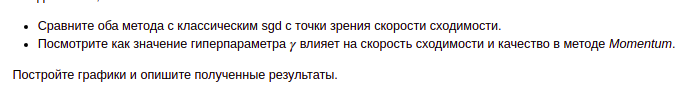

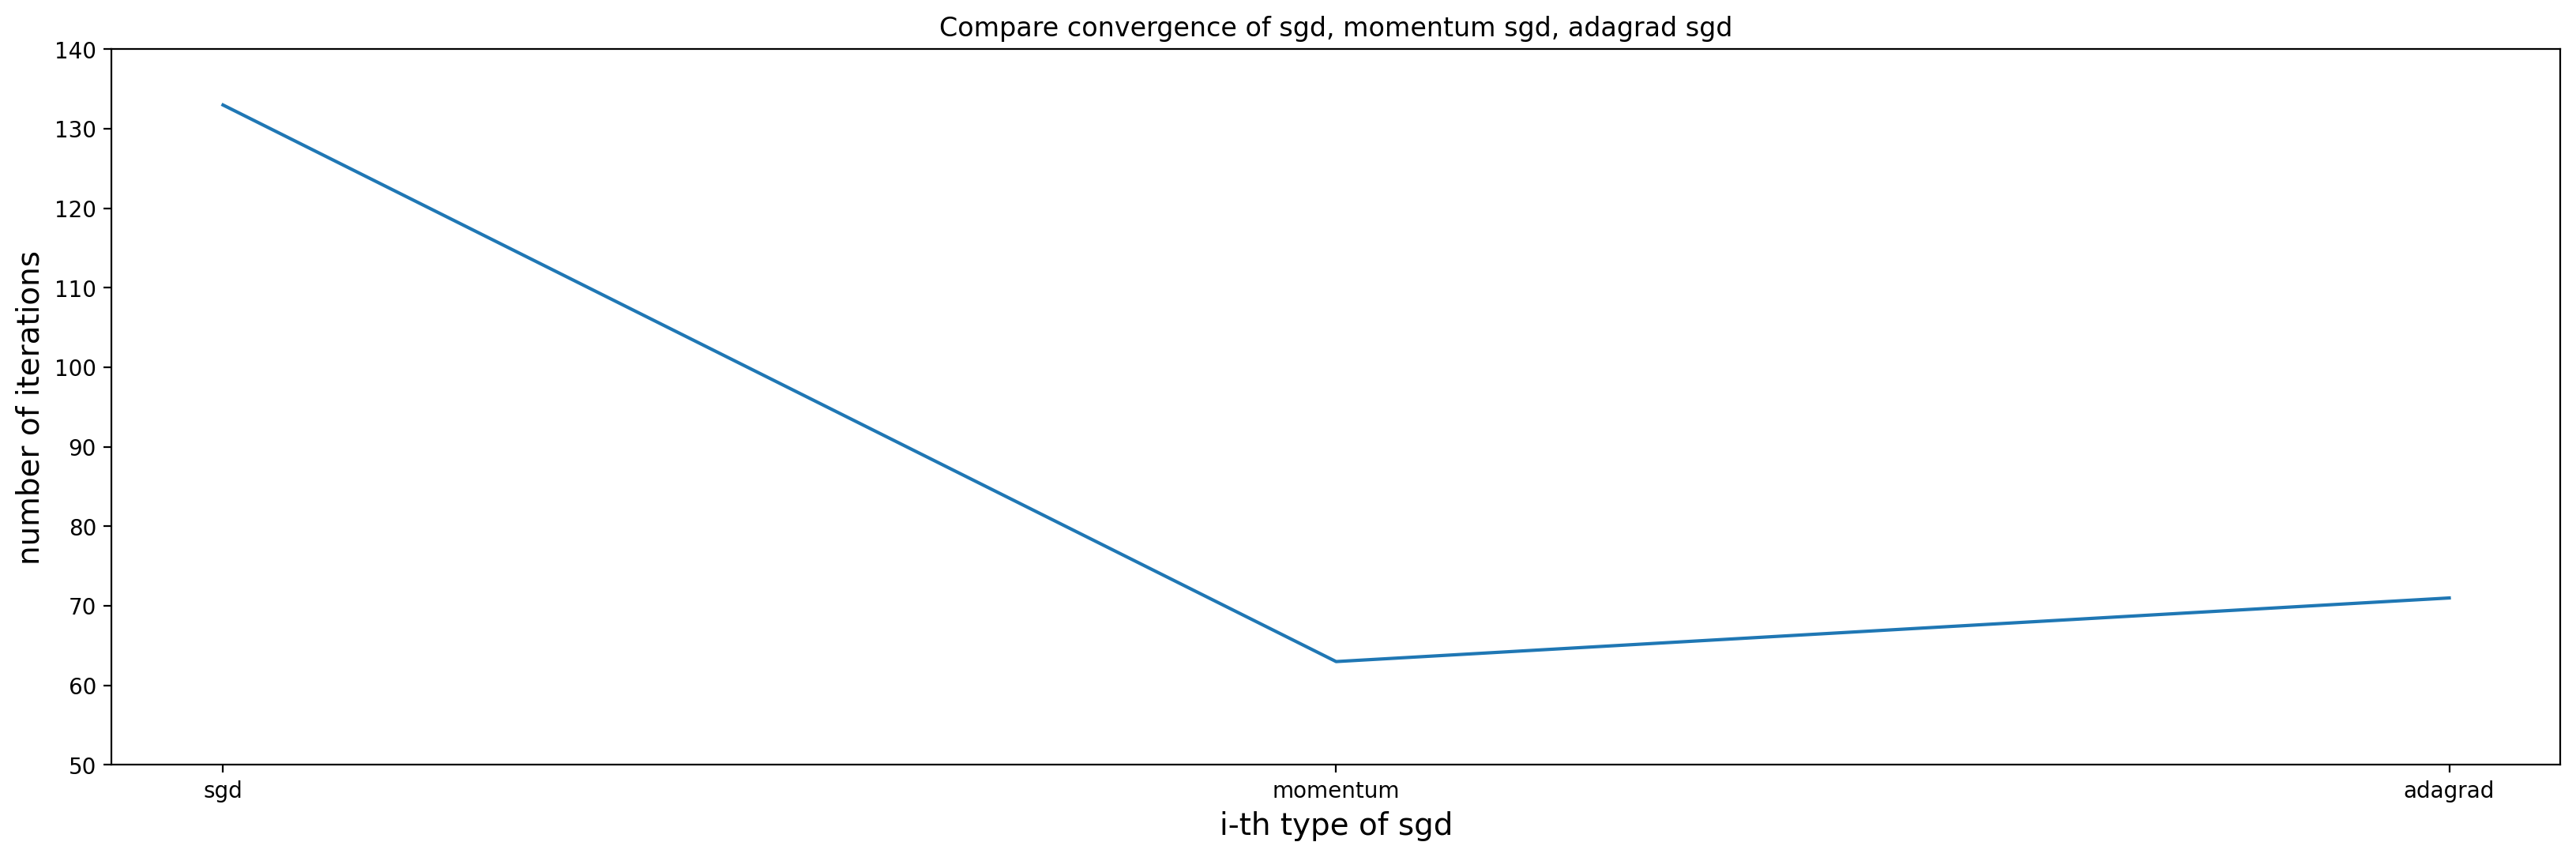

In [917]:
fig = figure(num=None, figsize=(20, 6), dpi=200, facecolor='w', edgecolor='k')
    
plt.xticks(list(range(3)), ['sgd', 'momentum', 'adagrad'])
plt.plot([number_of_iterations_for_SGD_lr[5], CPHM_SGD_Momentum.number_of_iterations(), 
          CPHM_SGD_Adagrad.number_of_iterations()])
plt.ylim(bottom = 50, top = 140)
plt.xlabel('i-th type of sgd', fontsize=14)
plt.ylabel('number of iterations', fontsize=14)
plt.title("""Compare convergence of sgd, momentum sgd, adagrad sgd""")
plt.show()

In [ ]:
fig = figure(num=None, figsize=(20, 6), dpi=200, facecolor='w', edgecolor='k')
    
plt.xticks(list(range(3)), ['sgd', 'momentum', 'adagrad'])
plt.plot([number_of_iterations_for_SGD_lr[5], CPHM_SGD_Momentum.number_of_iterations(), 
          CPHM_SGD_Adagrad.number_of_iterations()])
plt.ylim(bottom = 50, top = 140)
plt.xlabel('i-th type of sgd', fontsize=14)
plt.ylabel('number of iterations', fontsize=14)
plt.title("""Compare convergence of sgd, momentum sgd, adagrad sgd""")
plt.show()

Text(0.5, 1.0, 'Compare quality of momentum sgd for different momentum terms')

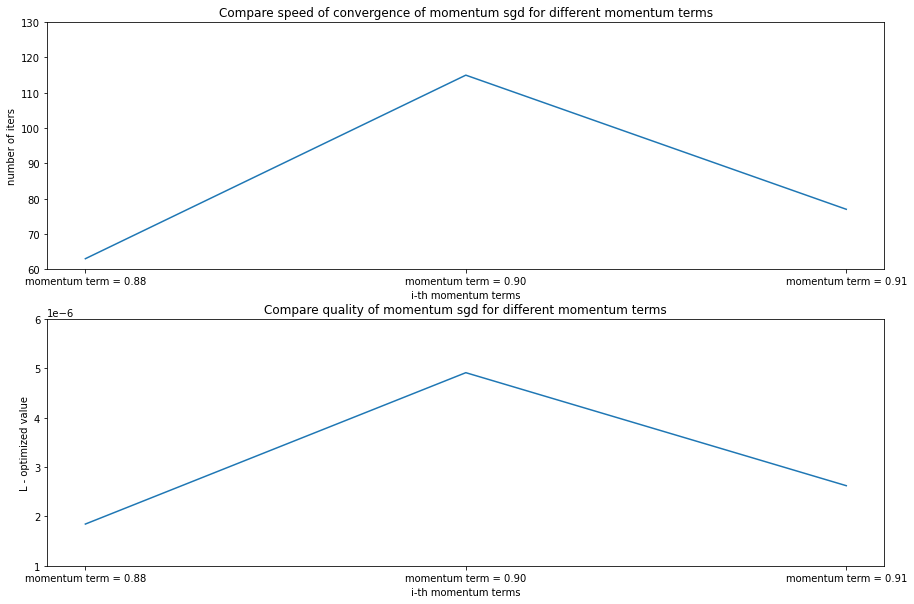

In [934]:
fig, ax = plt.subplots(2, 1, figsize = (15,10))

plt.setp(ax, xticks=list(range(3)), xticklabels=['momentum term = 0.88', 
                                                 'momentum term = 0.90', 
                                                 'momentum term = 0.91'])
# plt.xticks(list(range(3)), ['momentum term = 0.88', 'momentum term = 0.90', 'momentum term = 0.91'])
ax[1].set_ylim(bottom=0.000001, top=0.000006)
ax[0].set_ylim(bottom=60, top=130)

ax[0].plot([CPHM_SGD_Momentum.number_of_iterations(), 
            CPHM_SGD_Momentum_x.number_of_iterations(), 
            CPHM_SGD_Momentum_xx.number_of_iterations()])
ax[0].set_xlabel('i-th momentum terms', fontsize=10)
ax[0].set_ylabel('number of iters', fontsize=10)
ax[0].set_title("Compare speed of convergence of momentum sgd for different momentum terms")

ax[1].plot([optimized_values_for_SGD_Momentum[-1], 
            optimized_values_for_SGD_Momentum_x[-1], 
            optimized_values_for_SGD_Momentum_xx[-1]])
ax[1].set_xlabel('i-th momentum terms', fontsize=10)
ax[1].set_ylabel('L - optimized value', fontsize=10)
ax[1].set_title("Compare quality of momentum sgd for different momentum terms")

##### Answer:
###### momentum:

Прям с первого запуска увидел какое нереальное ускорение получилось и улучшение результата)))) вау, я правда результат смотрел для неоткалиброванной модели ещё, но всё же). Пожалуй стоит вкратце описать Momentum и Adagard, в чём их суть и почему что-либо улучшают.

Для моментума у нас такая суть, что если градиент показывают в одну сторону, то мы движемся всё быстрее и быстрее, если же градиент изменяет направление, то мы замедляем изменение весов, по сути, аналогия этому, это скатывание шарика с поверхности, а моментум наш отвечает за физический процесс ускорения (как и с шариком когда он катится в одну сторону), так и процесс замедления при изменении направления, очень хороший пример в одной из визуализаций по ссылке твоей, Вить, спасибо (https://imgur.com/a/Hqolp) :)

###### adagrad:

Ну, вообще суть алгоритма в том, что мы определям свой learning_rate для каждого веса меняя его в ходе дела, а именно, для тех фич, что чаще встречаются мы определяем медленную скорость, мол они и так меняются у нас стабильно, а для тех фич, что редкие, мы скорость даём большую. Это прям невероятный буст даёт для разряженных данных, и тот пример, что в одной из статей, мол помогло гуглу на ютубе котиков в видео находить, мне кажется я про него даже слышал годик другой назад на одной конференции :)

**Задание 12** Предсказание с помощью CPHM, интерфейс sklearn (1 балл)


Чтобы сравнить CPHM с предыдущими моделями, надо научиться предсказывать целевую переменную. С помощью значений персональной функции риска $\hat H_{Cox}(x, t)$ можно выразить вероятность того, что человек в течение 5 лет не заболеет при условии, что он не прекратит участие в эксперементе по другим причинам. Вероятность того, что человек не прекратит участие в эксперименте, оставаясь здоровым, также можно оценить из данных.

Реализуйте модель CPHM, унаследовав класс модели от [BaseEstimator](https://scikit-learn.org/stable/modules/generated/sklearn.base.BaseEstimator). Модель должна поддерживать методы fit, predict, predict_proba. Это вам позволит в следующем задании её откалибровать. При тестировании модели следует передать то время, через которое вас интересует состояние пациента (в случае конкурса, 5 лет).



In [611]:
class CPHazard_SGD_Model(BaseEstimator):
    # weight_init - 'random', 'zeroes', default = 'random' unifrom(0, precision * 100)
    # learning_rate - float, default = 0.01
    # C, коэффициент регуляризации, float, default = 0.0
    # max_iter - int, default = 100
    # precision - float, default = 1e-4
    # hazard_func - func, default = hazard_function defined higher
    # batch_size = float, default = 10 = 10% of elements
    
    def __init__(self, hazard_func = hazard_function, weights_init='random', learning_rate = 0.01, C = 0.0,
                 max_iters = 100, precision = 0.0001, batch_size = 10):
        self.weights_init = weights_init
        self.learning_rate = learning_rate
        self.C = C
        self.max_iters = max_iters
        self.iters = 0
        self.precision = precision
        self.cur_precision = math.inf
        self.weights = np.array(0)
        self.previous_weights = np.array(0)
        self.hazard_func = hazard_func
        self.X = None
        self.y = None
        self.X_last_follow_ups = None
        self.gradient = self.gradient_for_CPHazard
        self.mine_optimized_value_func = self.mine_optimized_value
        self.optimized_values = list()
        self.batch_size = batch_size
        
    def fit(self, X, y):
        self.X = np.array(X)
        self.y = np.array(y)
        # self.X_last_follow_ups = np.array(last_follow_ups)
        self.X_last_follow_ups = np.array(np.random.uniform(2, 7, self.X.shape[0]))
        if (self.weights_init == 'zeroes'):
            self.weights = [0] * X.shape[1]
            
        if (self.weights_init == 'random'):
            self.weights = np.random.uniform(0, self.precision * 100, X.shape[1])
            
        if (self.weights_init == 'random_second_test'):
            self.weights = 10 * np.random.uniform(0, self.precision * 100, X.shape[1])
            
        if (self.weights_init == 'random_third_test'):
            self.weights = 100 * np.random.uniform(0, self.precision * 100, X.shape[1])
            
        if (self.weights_init == 'random_forth_test'):
            self.weights = 300 * np.random.uniform(0, self.precision * 100, X.shape[1])
            
        if (self.weights_init == 'standart'):
            self.weights = np.random.uniform(-1, 1, X.shape[1])
            self.weights /= self.X.shape[0]
            
        self.weights = np.array(self.weights)    
        n = 100
        #print(self.weights)
        
        while self.cur_precision > self.precision and self.iters < self.max_iters:
            self.previous_weights = self.weights 
            #print(self.weights)
            
            indicies = np.array(random.sample(range(0, n), int(n * self.batch_size / 100)))
            #print(indicies)
            #
            self.weights = self.weights - self.learning_rate * self.gradient(indicies) - \
                self.learning_rate * self.C * self.weights
            
            self.cur_precision = norm(self.weights - self.previous_weights) 
            #print(self.gradient())
            #print(self.cur_precision)
            self.iters += 1 
            #print("Iteration ", self.iters ,"\nweights are ", self.weights)    
            #print("Iteration ", self.iters)    
            self.optimized_values.append(self.mine_optimized_value_func(indicies))
            #print("new value = " + str(self.mine_optimized_value_func()))
            #print(self.optimized_values)
        return self
        
    def predict_proba(self, X_test, t = 5):
        # t - years, to which we predict, default = 5
        return self.hazard_func(t) * np.exp(np.dot(X_test, self.weights))
        
    def predict(self, X_test, t = 5):
        return np.random.choice(1, p = predict_proba(X_test, t))
    
    def number_of_iterations(self):
        return self.iters
    
    def get_optimized_values(self):
        return np.array(self.optimized_values)
    
    def gradient_for_CPHazard(self, batch_indexes):
        N = batch_indexes.shape[0]
        gradient = 0
        for i in batch_indexes:
            helper = np.exp(self.X[i] @ self.previous_weights)
            # print(helper)
            gradient -= self.X[i] * self.y[i]
        
            second_part = self.hazard_func(self.X_last_follow_ups[i]) * helper
            #print("second check: " + str(np.exp(self.X[i] @ self.previous_weights)))
            #print(self.hazard_func(self.X_last_follow_ups[i]))
            #print(second_part.shape)
            gradient += (1 - self.y[i]) * second_part * self.X[i] / (1 - second_part)
            #print("second_part =  " + str(((1 - self.y[i]) * second_part * self.X[i] / (1 - second_part))) + " " + \
            #      str(((1 - self.y[i]) * second_part / (1 - second_part))) + " ")
            
            third_part = 0
            for j in np.arange(int(self.X_last_follow_ups[i])):
                third_part_helper = self.hazard_func(j) * helper
                third_part += third_part_helper * self.X[i] / (1 - third_part_helper)
            #print("third_part = " + str(third_part))
            
            gradient += third_part
        return gradient / N
    
    def mine_optimized_value(self, batch_indexes):
        N = 100
        value = 0
        for i in np.arange(N):
            # PREV or CUR WEIGHTS, Can change output for first iterations
            helper = self.X[i] @ self.previous_weights
            helper_exp = np.exp(helper)
            
            first_part = self.y[i] * (np.log(self.hazard_func(self.X_last_follow_ups[i])) + helper)
            #print("optimized first_part = " + str(first_part))
            
            second_part = (1 - self.y[i]) * (np.log(1 - self.hazard_func(self.X_last_follow_ups[i]) * helper_exp))
            #print("optimized second_part = " + str(second_part))
            third_part = 0
            for j in np.arange(int(self.X_last_follow_ups[i])):
                third_part += np.log(1 - self.hazard_func(j) * helper_exp)
            #print("optimized third_part = " + str(third_part))
            #print("part of thrid_part = " + str(self.hazard_func(j) * np.exp(self.X[i] @ self.previous_weights)))
            value += first_part + second_part + third_part
        
        value = -1 * value / N
        return value


**Задание 13** Калибровка классификатора (2 балла)

Сравнительно простой способ уточнить оценки вероятности и уменьшить logloss -- откалибровать модель. Вообще говоря, сравнивать между собой некалиброванные модели по logloss некорректно: хорошая модель с нарушенной калибровкой может иметь сколь угодно большое значение logloss.

Идея калибровки состоит в том, чтобы подобрать простое преобразование, которое превратит выходы моделей в вероятности принадлежности классам.

Есть несколько известных методов калибровки:
 - Калибровка Платта.
 - Изотоническая регрессия.

Обратите внимание, что преобразование необходимо обучать на отложенной выборке (то есть классификатор и калибровка должны обучаться на разных подмножествах данных), иначе можно переобучиться. Калибровку можно применять к любым классификаторам (где это разумно и необходимо), особенно к тем, которые не оптимизируют logloss явно.

Для калибровки классификатора в sklearn возможны два подхода:
 - взять уже обученный классификатор и откалибровать его на отложенной выборке
 - откалибровать по кросс-валидации: калибровочному классификатору передается вся обучающая выборка, которая внутри разбивается на обучающую и калибровочную, после чего происходит усреднение вероятностей по фолдам.
 
Подробнее об этом можно прочитать в [документации](http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html#sklearn.calibration.CalibratedClassifierCV). Также [здесь](https://jmetzen.github.io/2015-04-14/calibration.html) можно узнать подробности о калибровке в sklearn от автора.

Используйте оба описанных выше подхода (калибровку Платта и изотоническую регрессию) для калибровки моделей, построенных в лабораторной работе. Для каждой модели постройте график, на котором будут изображены [калибровочные кривые](http://scikit-learn.org/stable/modules/generated/sklearn.calibration.calibration_curve.html): идеальная, исходного классификатора, а также для каждого из методов. Калибровочная кривая строится путем упорядочения всех объектов по предсказанному значению, которые разбиваются на бины. По оси OX откладывается среднее предсказанное значение вероятности по бину, а по OY — доля положительных примеров. В случае идеальных вероятностей это будет прямая.
 


In [523]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

In [659]:
import matplotlib
matplotlib.use("svg")
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

from sklearn import datasets
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score, log_loss)

In [553]:
indicies = random.sample(range(X_train.shape[0]), X_train.shape[0])
train = np.array(indicies[0 : int(X_train.shape[0] * 0.75)])
calib = np.array(indicies[int(X_train.shape[0] * 0.75) : int(X_train.shape[0] * 0.90)])
test = np.array(indicies[int(X_train.shape[0] * 0.90) : X_train.shape[0]])
print(train.shape, calib.shape, test.shape)

(75000,) (15000,) (10000,)


In [581]:
X_additional = X_train[['Fasting plasma glucose (final visit)', 'Diabetes diagnosed during followup', 
                        'censor of diabetes at followup', 'year of followup']]

X_lab_train_last = X_train.iloc[train]
X_lab_calib_last = X_train.iloc[calib]
X_lab_test_last = X_train.iloc[test]
X_lab_train_additional_last  = X_additional.iloc[train]['year of followup']
X_lab_calib_additional_last  = X_additional.iloc[calib]['year of followup']
X_lab_test_additional_last  = X_additional.iloc[test]['year of followup']
y_lab_train_last = y_train.iloc[train]
y_lab_calib_last = y_train.iloc[calib]
y_lab_test_last = y_train.iloc[test]

In [586]:
X_lab_train_last = X_lab_train_last.drop(columns=['Fasting plasma glucose (final visit)', 'Diabetes diagnosed during followup', 
                        'censor of diabetes at followup', 'year of followup'])
X_lab_calib_last = X_lab_calib_last.drop(columns=['Fasting plasma glucose (final visit)', 'Diabetes diagnosed during followup', 
                        'censor of diabetes at followup', 'year of followup'])
X_lab_test_last = X_lab_test_last.drop(columns=['Fasting plasma glucose (final visit)', 'Diabetes diagnosed during followup', 
                        'censor of diabetes at followup', 'year of followup'])

In [587]:
print(X_lab_train_last.shape)
print(X_lab_calib_last.shape)
print(X_lab_test_last.shape)
print(X_lab_train_additional_last.shape)
print(X_lab_calib_additional_last.shape)
print(X_lab_test_additional_last.shape)
print(y_lab_train_last.shape)
print(y_lab_calib_last.shape)
print(y_lab_test_last.shape)

(75000, 20)
(15000, 20)
(10000, 20)
(75000,)
(15000,)
(10000,)
(75000, 1)
(15000, 1)
(10000, 1)


In [541]:
y_lab_test = y_lab_test.to_numpy()
y_lab_train = y_lab_train.to_numpy()

In [651]:
lr = LogisticRegression(max_iter=10000)
gnb = GaussianNB()
lda = LinearDiscriminantAnalysis()
qda = QuadraticDiscriminantAnalysis()

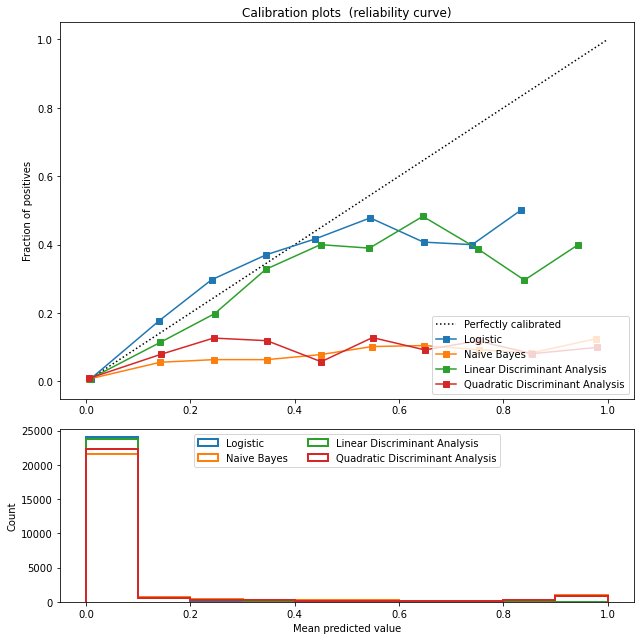

In [686]:
plt.figure(figsize=(9, 9))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
for clf, name in [(lr, 'Logistic'),
                  (gnb, 'Naive Bayes'),
                  (lda, 'Linear Discriminant Analysis'),
                  (qda, 'Quadratic Discriminant Analysis')]:
    clf.fit(X_lab_train, np.array(y_lab_train).ravel())
    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(X_lab_test)[:, 1]
    else:  # use decision function
        prob_pos = clf.decision_function(X_lab_test)
        prob_pos = \
            (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
    fraction_of_positives, mean_predicted_value = \
        calibration_curve(np.array(y_lab_test).ravel(), prob_pos, n_bins=10)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % (name, ))

    ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
             histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()

In [668]:
def plot_calibration_curve(est, name, fig_index):
    """Plot calibration curve for est w/o and with calibration. """
    # Calibrated with isotonic calibration
    isotonic = CalibratedClassifierCV(est, cv=2, method='isotonic')

    # Calibrated with sigmoid calibration
    sigmoid = CalibratedClassifierCV(est, cv=2, method='sigmoid')

    # Logistic regression with no calibration as baseline
    lr = LogisticRegression(C=1., solver='lbfgs')

    fig = plt.figure(fig_index, figsize=(9, 9))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    for clf, name in [(est, name),
                      (isotonic, name + ' + Isotonic'),
                      (sigmoid, name + ' + Sigmoid')]:
        clf.fit(X_lab_train, y_lab_train)
        y_pred = clf.predict(X_lab_test)
        y_pred = constant_answer
        if hasattr(clf, "predict_proba"):
            prob_pos = clf.predict_proba(X_lab_test)[:, 1]
        else:  # use decision function
            prob_pos = clf.decision_function(X_lab_test)
            prob_pos = \
                (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())

        clf_score = brier_score_loss(y_lab_test, prob_pos, pos_label=y.max())
        #print("%s:" % name)
        #print("\tBrier: %1.3f" % (clf_score))
        #print("\tPrecision: %1.3f" % precision_score(y_lab_test, y_pred))
        #print("\tRecall: %1.3f" % recall_score(y_lab_test, y_pred))
        #print("\tF1: %1.3f\n" % f1_score(y_lab_test, y_pred))

        fraction_of_positives, mean_predicted_value = \
            calibration_curve(y_lab_test, prob_pos, n_bins=10)

        ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s (%1.3f)" % (name, clf_score))

        ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
                 histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper center", ncol=2)

    plt.tight_layout()

/home/elephant/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/elephant/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/elephant/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


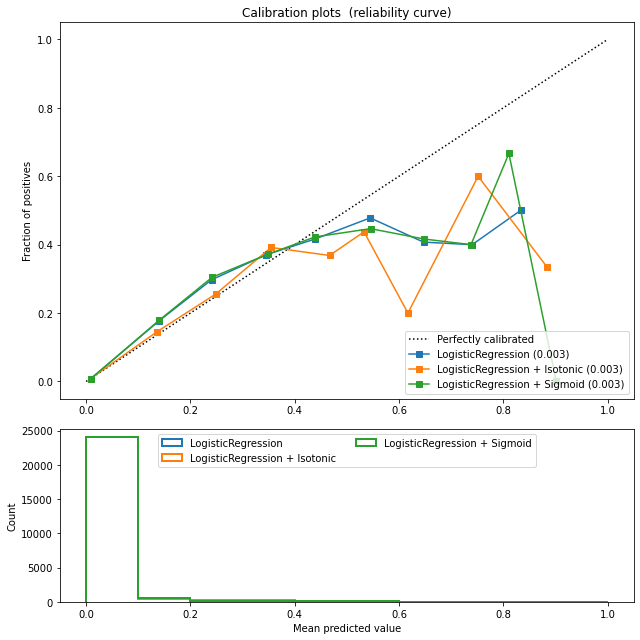

In [669]:
plot_calibration_curve(LogisticRegression(max_iter=10000), "LogisticRegression", 2)

/home/elephant/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/elephant/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/elephant/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


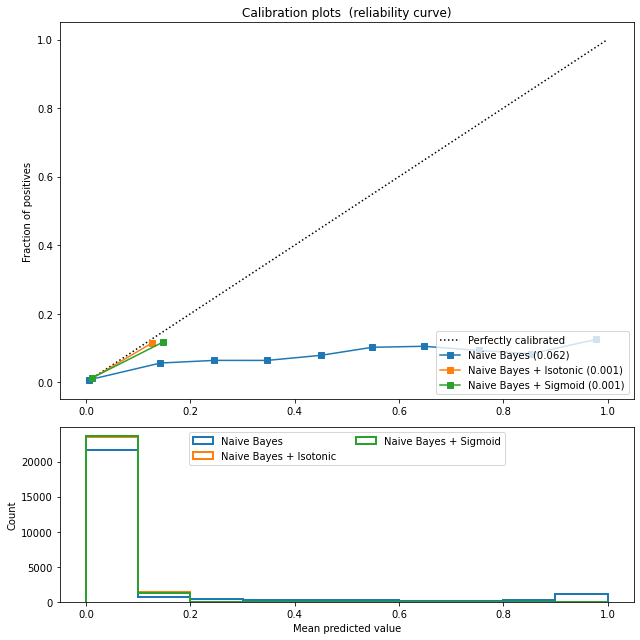

In [673]:
plot_calibration_curve(GaussianNB(), "Naive Bayes", 2)

/home/elephant/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/elephant/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/elephant/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


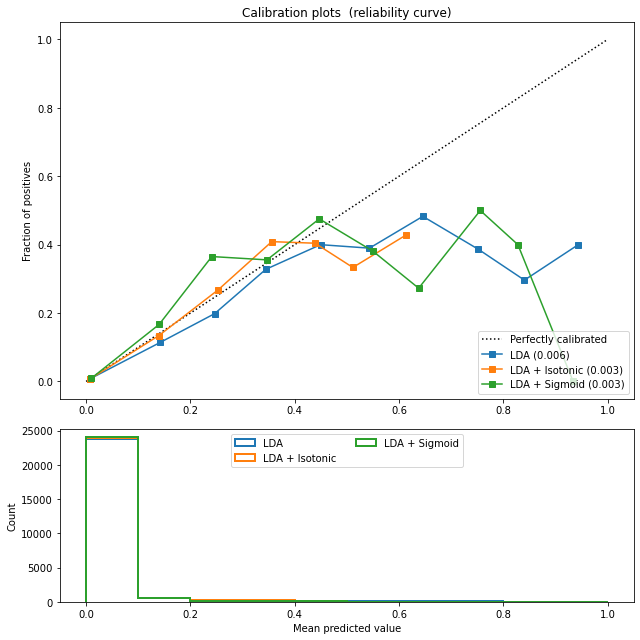

In [674]:
plot_calibration_curve(LinearDiscriminantAnalysis(), "LDA", 2)

/home/elephant/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/elephant/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/elephant/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


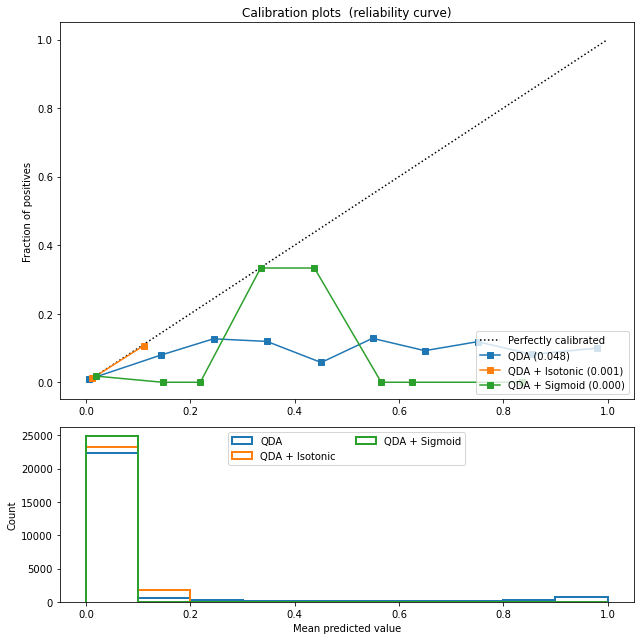

In [675]:
plot_calibration_curve(QuadraticDiscriminantAnalysis(), "QDA", 2)

Собственно понятно что эта за штука, увеличивает уверенность результате, т.к. не слепо смотрит на predict, но и оценивает вероятности. Она помогает нам лучше представлять что в действительности происходит, если например мы в бинарной классификации предсказали 0.51 для первого класс и 0.49 для второго класса, и так для каждого объекта, то воспользовавшись калибровкой можно понять, что первый класс появляется дааалеко не со сто процентной вероятностью, хотя такой вывод можно было бы сделать, если перевести вероятности к принадлежности к классу 1 или 0. В общем, после калибровки предсказанные вероятности более уверенные результаты показывают.

Выполнив задания, не забудьте отправить решение в [конкурс](https://www.kaggle.com/c/competition-2-yandex-shad-spring-2021)

**Выводы** (1.5 балла)

- Какие есть достоинства и недостатки у рассмотренных в лабораторной работе моделей?
- Какие модели сильно улучшили свой logloss после калибровки, а какие - нет? Почему так произошло?
- Какие из рассмотренных методов могут обучиться на маленьких датасетах? А какие применимы для очень больших датасетов? Какие проблемы могут возникнуть при применении к большим датасетам и как их можно решить?


##### Линейная регрессия:
Лучше больше данных, плохо если их мало. Нужно серьёзно обрабатывать данные, выбросы, нормализация желательно, как минимум.

Калибровка не даёт выйгрыша, ведь модель впринципе так работает, что выдаёт уже калиброванные результаты.

Достоинства:
1. Суперски работает, если данные разделяемы линейно
2. Легко понять как работает, легко обучить
3. Куча проблем решается обычной регуляризацией, гиперпараметр которой можно просто подобрать

Недостатки:
1. Данные очень часто не разделяемы линейно :(
2. На самом деле другие недостатки нас особо не затронули в данной работе, но вообще сильно мешают выбросы, коллинеарность в данных, слишком всё упрощает

##### Наивный байес:
Супер если данных мало, ну, важно насколько независимость для данных верна оказалась.

Калибровка, нууу, наивный байес так работает, что на его вероятности вообще впринципе смотреть не стоит. Просто с ним так выходит, что когда мы уже присваем лейбел класса каждому объекту, то иногда функция правдоподобия прям супер близкие значения к оптимуму приобретает, и при том такое нередко случается, поэтому байес наивный и популярен обственно, но не из-за вероятностей самих предсказанных.

Достоинства:
1. Просто невероятно крут, если предположение близко к правде, или действительно верно
2. Снова невероятно крут для маленьких наборов данных
3. Тут особо с этим не работали, но для признаков категориалных тоже шикарен

Недостатки:
1. предположение о независимоси фичей не выполняется почти всегда (особенно в задачах реального мира)
2. predict_proba у него, кхм, ну оочень очень не стоит на неё смотреть

##### Линейный дискриминантный анализ - для двух классов аналогична линейной регрессии:
Просто добавлю, что и то и то плохо работает для маленького количества данных. Так же круто, что очень старается разделить как можно дальше центры обоих классов. 1й недостаток из квадратичного дискр анализа.

##### Квадратичный дискриминантный анализ
Достоинства:
1. Очень точная и крутая достаточно часто из-за подсчётов

Недостатки:
1. предположение о нормальном распределении 
2. долго учится
3. тяжёлые операции с матрицами